# Imports

In [1]:
%%time
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from lmfit import minimize, Parameter, Parameters, report_fit
from IPython import display

CPU times: total: 1.06 s
Wall time: 1.07 s


# Model diagram

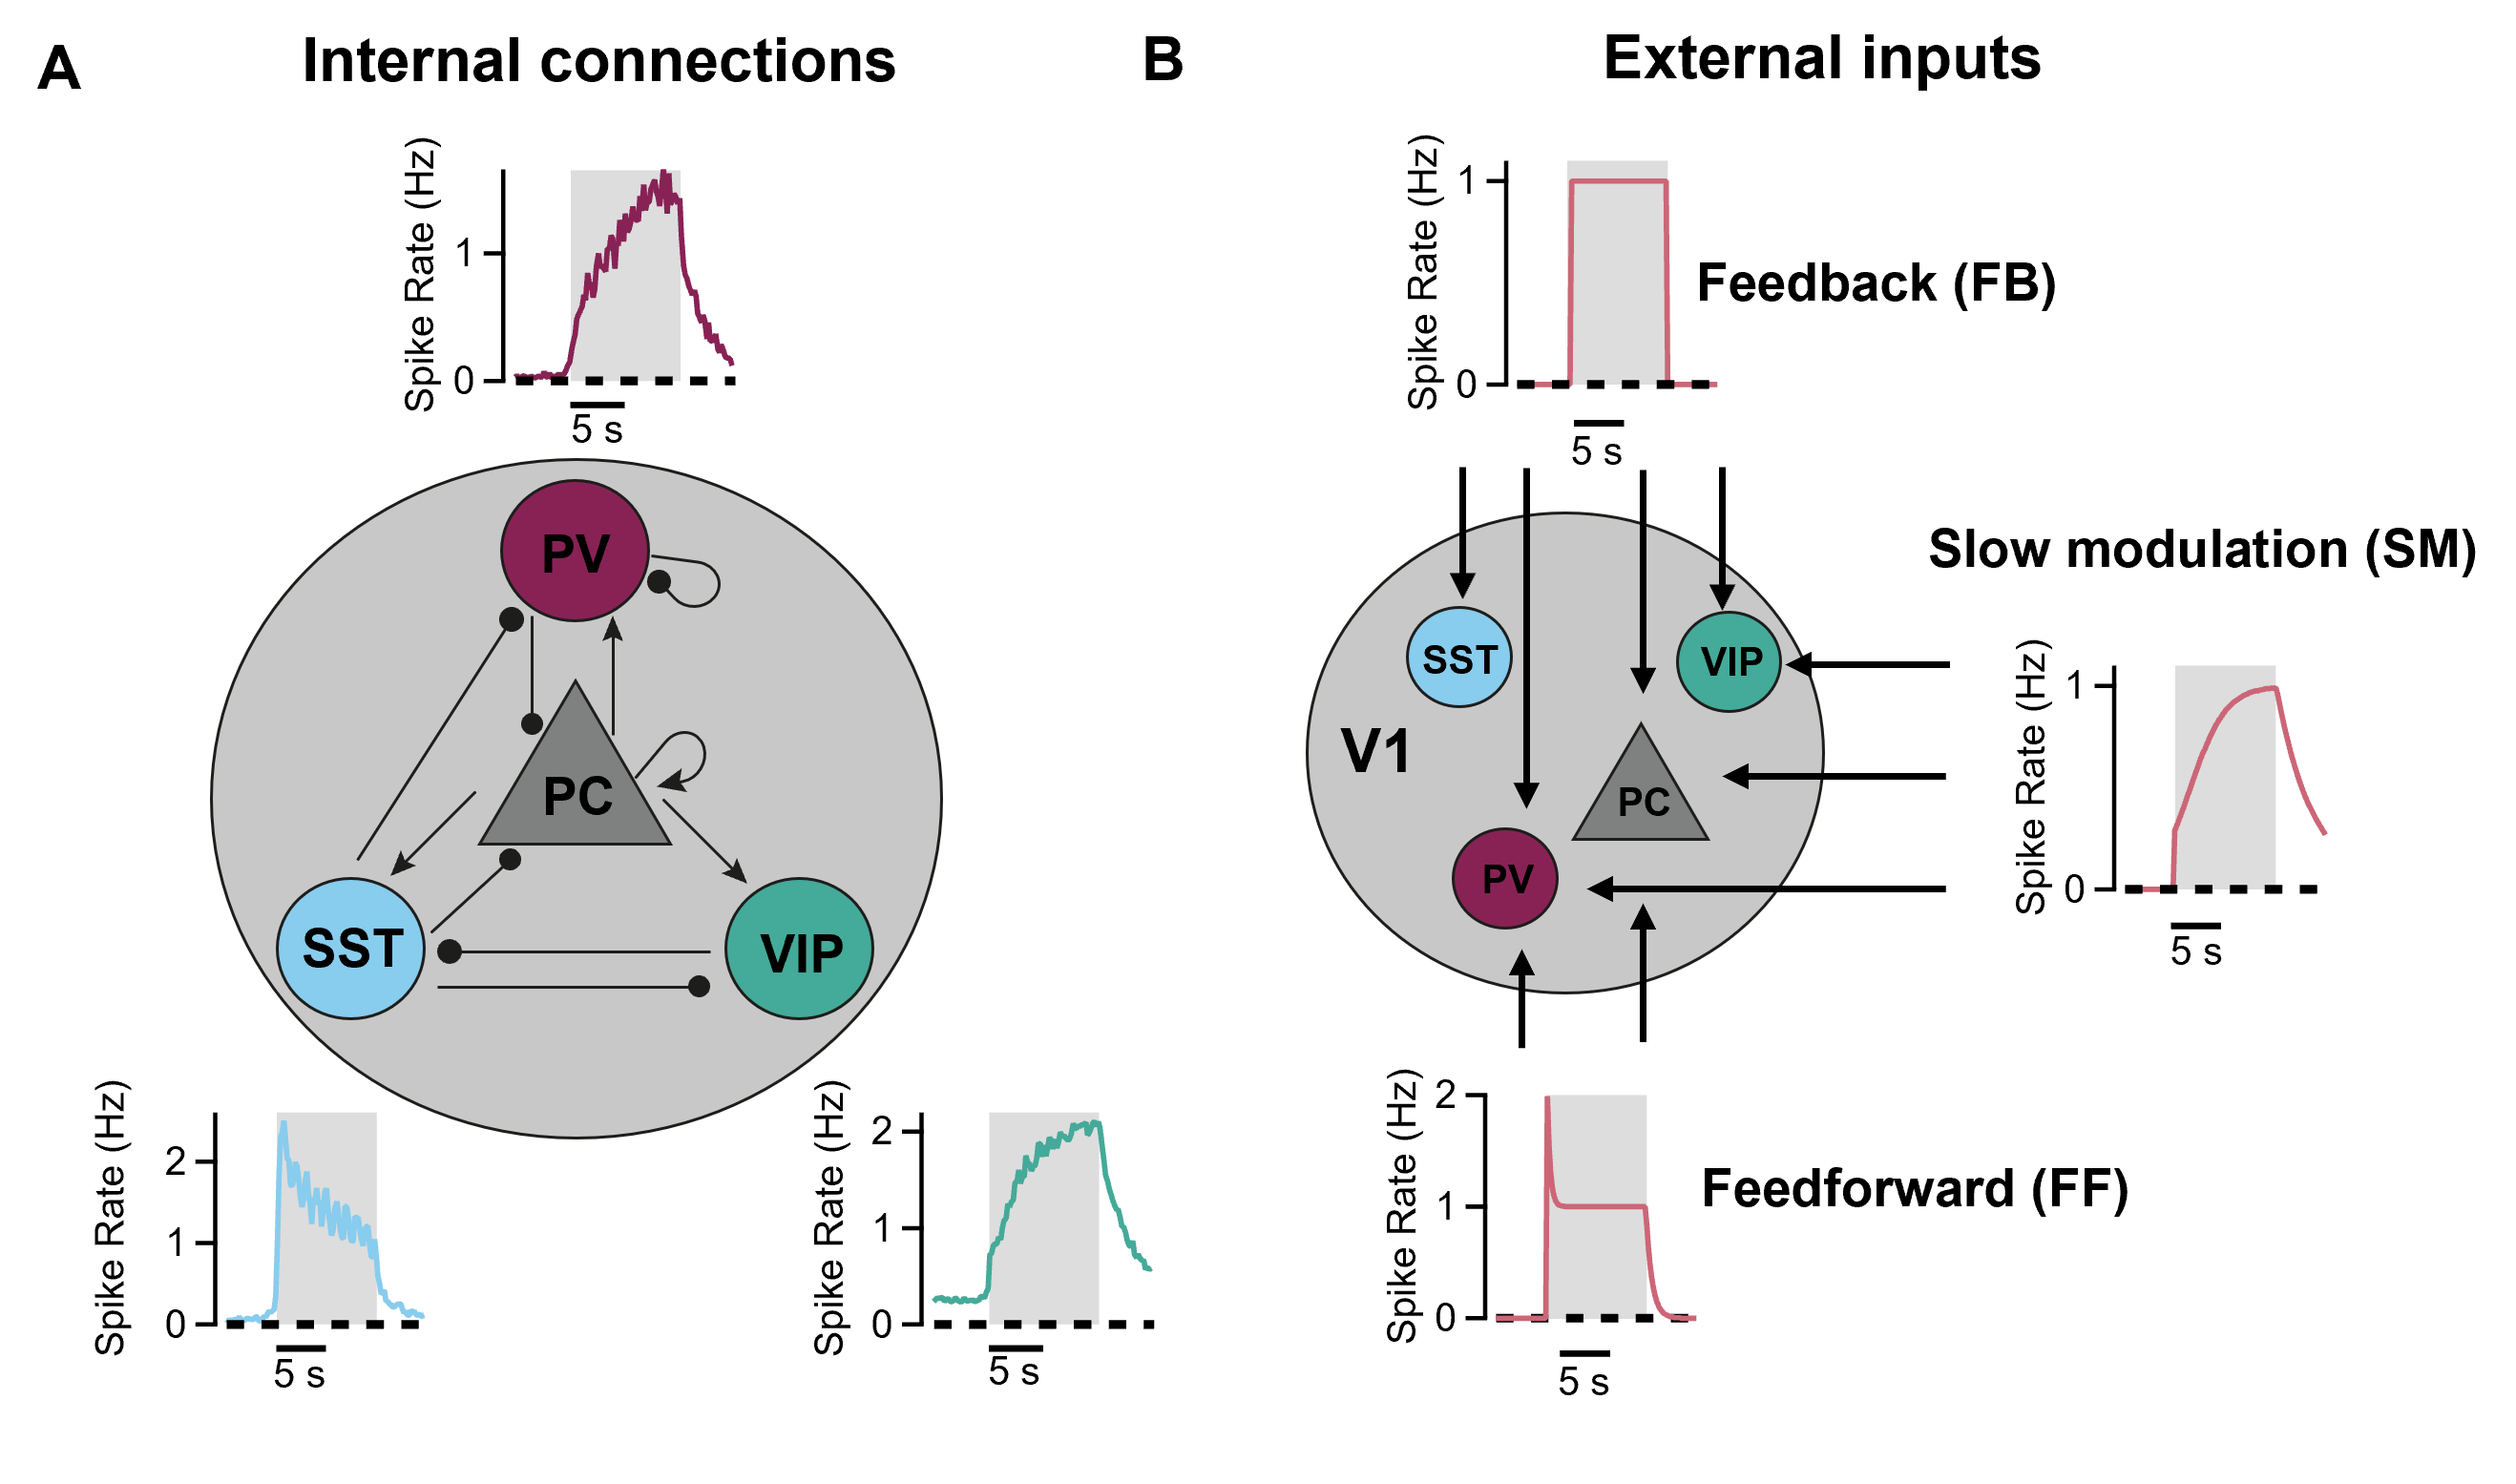

In [2]:
display.Image(filename=r'Model_diagram.png', width=700, height=1000)

<p><strong>Fig. 4</strong> from the paper.</p>
<hr>

# Functions

In [3]:
def Step(t, stim = 5, inter = 10, amp = 1.0, base = 0, k = 0, delay = 0):
    """
    Feedback (FB) input:
    ------------------------------------
    Represented as a step function. Returns value of the input function in a time point t.
    ------------------------------------
    Parameters:
    
    t (running)             - time in seconds;
    stim (fixed) = 5 s      - time of the stimulus start;
    inter (fixed) = 10 s    - duration of the stimulus;
    amp (fixed) = 1.0 Hz    - amplitude of response;
    base (fixed) = 0 Hz     - baseline activity;
    k (fixed) = 0           - slope of the slow component. Used to be varied while testing linear depression or sensitization component in the FB input;
    delay (variable)        - delay of the FB input to the cell relative to the stimulus start;

    """
    
    if (t < stim + delay) or (t > stim + inter):
        h = base
        
    else:
        h = amp*(t - stim - delay)*k*0.164745 + amp
    
    return h

In [4]:
def Sigm(t, stim = 5, inter = 10, ampl = 1.0, base = 0, rate = 1, delay = 0, decay_s = 1, dt = 0.164745):
    """
    Slow modulation (SM) input:
    ------------------------------------
    Represented as a sigmoid function. Returns value of the input function in a time point t.
    ------------------------------------
    Parameters:
    
    t (running)               - time in seconds;
    stim (fixed) = 5 s        - time of the stimulus start;
    inter (fixed) = 10 s      - duration of the stimulus;
    ampl (variable)           - amplitude of response;
    base (fixed) = 0 Hz       - baseline activity;
    rate (variable)           - time-constant of the SM input;
    delay (variable)          - shift of the sigmoid center relative to stimulus start;
    decay_s (varaible)        - time-constant of the SM input exponential decay after the end of stimulation;
    dt (fixed) = 0.164745 s   - one timepoint shift of the function due to 1 timepoint later endings of PV and VIP traces (see Methods in a paper)

    """
    
    if (t < stim):
        h = base

    elif (t > stim + inter + dt):
        h = (base + (ampl/(1 + np.exp((delay-inter - dt)/rate))))*np.exp(-(t - stim - inter - dt)*decay_s) + base
    
    else:
        h = base + (ampl/(1 + np.exp((stim + delay - t)/rate))) #Actualy rate here is time-constant, where 1/rate is actual rate
        
    
    return h

In [5]:
def expon(t, stim = 5, inter = 10, ampl = 1.5, base = 0, decay = 1, delay = 0, b = 0, decay_ff = 0):
    """
    Feedforward (FF) input:
    ------------------------------------
    Represented as a flat step function with fast exponential decay on the stimulus start. Returns value of the input function in a time point t.
    ------------------------------------
    Parameters:
    
    t (running)               - time in seconds;
    stim (fixed) = 5 s        - time of the stimulus start;
    inter (fixed) = 10 s      - duration of the stimulus;
    ampl (variable)           - amplitude of peak;
    base (fixed) = 1 Hz       - steady-state firing rate after fast exponential depression;
    decay (variable)          - time-constant of the fast exponential depression;
    delay (variable)          - delay of the FF input to the cell relative to the stimulus start;
    b (fixed) = 0 Hz          - baseline activity;
    decay_ff (varaible)       - time-constant of the FF input exponential decay after the end of stimulation;

    """
    if (t < stim + delay):
        h = b

    elif (t > stim + inter):
        h = (b + base + ampl*np.exp(-(inter-delay)*decay))*np.exp(-(t - stim - inter)*decay_ff)
    else:
        h = b + base + ampl*np.exp(-(t - stim - delay)*decay)
        
    return h

In [6]:
 def f_e_avg(t, data):
     """
    
     """    
    
     return np.interp(t, t_exp, data)

In [7]:
def model_step(t,
               y,
               w_0, w_1, w_2, w_3, w_4, w_5, w_6, w_7, w_8, w_9, w_10, w_11, w_12, w_13, w_14, w_15, w_16, w_17, w_18,
               tau_0, tau_1, tau_2, tau_3,
               threshold,
               power,
               q,
               i_0, i_1, i_2, i_3,
               r_1, decay, delay_1, delay_2, delay_3, ampl, base, decay_s, ampl_1, base_sigm, decay_ff
               ):
    """
    Model basis:
    ------------------------------------
    Systems of first order differential equations that captures activity of populations without (df_xdt) and with (df_x_odt) optogenetic manipulations. 
    Returns an array of values of the derrivatives at a certain timepoint, calculated from values of functions in previous timepoint. 
    ------------------------------------
    Parameters:
    
    t (running)               - time in seconds;
    y (running)               - values of activities on the previous timepoint;
    w_x (variable)            - synaptic weights;
    tau_x (fixed)             - neurons time-constants;
    threshold (fixed) = 0 Hz  - minimum rectification value;
    power (fixed) = 2         - value of the power in the input-output function;
    q (fixed) = 1             - normalization coeficient in the input-output function;
    i_x (variable)            - baseline activity of neurons;
    ...
    
    """
    
    # Inicialization of initial values obtained from previous timepoint        
    
    f_e, f_p, f_s, f_v, f_e_o, f_p_o, f_s_o, f_v_o = y

    # System of equations that captures total populational input for ff_e - PC, ff_p - PV, ff_s - SST, ff_v - VIP
    
    ff_e = (min(max((i_0 + w_0 * f_e + w_1 * expon(t, ampl = ampl, base = base, decay = decay, delay = delay_1, decay_ff = decay_ff) + w_2 * Sigm(t, ampl = ampl_1, rate = r_1, delay = delay_2, decay_s = decay_s, base = base_sigm) + w_16 * Step(t, k = 0, delay = delay_3) - w_3 * f_p - w_4 * f_s), threshold), 25))
    ff_p = (min(max((i_1 + w_17 * Step(t, k = 0, delay = delay_3) + w_5 * f_e + w_6 * expon(t, ampl = ampl, base = base, decay = decay, delay = delay_1, decay_ff = decay_ff) + w_7 * Sigm(t, ampl = ampl_1, rate = r_1, delay = delay_2, decay_s = decay_s, base = base_sigm) - w_8 * f_p - w_9 * f_s), threshold), 25))
    ff_s = (min(max((i_2 + w_10 * f_e + w_11 * Step(t, k = 0, delay = delay_3) - w_12 * f_v), threshold), 25))
    ff_v = (min(max((i_3 + w_18 * Step(t, k = 0, delay = delay_3) + w_13 * f_e - w_14 * f_s +  w_15 * Sigm(t, ampl = ampl_1, rate = r_1, delay = delay_2, decay_s = decay_s, base = base_sigm)), threshold), 25))

    # Same for optogenetic
    
    ff_e_o = (min(max((i_0 + w_0 * f_e_o + w_1 * expon(t, ampl = ampl, base = base, decay = decay, delay = delay_1, decay_ff = decay_ff) + w_2 * Sigm(t, ampl = ampl_1, rate = r_1, delay = delay_2, decay_s = decay_s, base = base_sigm) + w_16 * Step(t, k = 0, delay = delay_3) - w_3 * f_p_o - w_4 * f_s_o), threshold), 25))
    ff_p_o = (min(max((i_1 + w_17 * Step(t, k = 0, delay = delay_3) + w_5 * f_e_o + w_6 * expon(t, ampl = ampl, base = base, decay = decay, delay = delay_1, decay_ff = decay_ff) + w_7 * Sigm(t, ampl = ampl_1, rate = r_1, delay = delay_2, decay_s = decay_s, base = base_sigm) - w_8 * f_p_o - w_9 * f_s_o), threshold), 25))
    ff_s_o = (min(max((i_2 + w_10 * f_e_o + w_11 * Step(t, k = 0, delay = delay_3) - w_12 * f_v_o), threshold), 25))
    ff_v_o = (min(max((i_3 + w_18 * Step(t, k = 0, delay = delay_3) + w_13 * f_e_o - w_14 * f_s_o +  w_15 * Sigm(t, ampl = ampl_1, rate = r_1, delay = delay_2, decay_s = decay_s, base = base_sigm)), threshold), 25))
    
    # Derrivatives calculated using input-output function
    
    df_edt = ((q * ff_e ** power) - f_e) / tau_0
    df_pdt = ((q * ff_p ** power) - f_p) / tau_1
    df_sdt = ((q * ff_s ** power) - f_s) / tau_2
    df_vdt = ((q * ff_v ** power) - f_v) / tau_3

    # Same for optogenetic. The scaling coefficient (here 1.6 in SST) is applied to introduce effect of optogenetic manipulation
    
    if (t>=5) and (t<=15):
        
        df_e_odt = ((q * (ff_e_o) ** power) - f_e_o) / tau_0
        df_p_odt = ((q * (ff_p_o) ** power) - f_p_o) / tau_1
        df_s_odt = ((q * (ff_s_o*1.6) ** power) - f_s_o) / tau_2
        df_v_odt = ((q * (ff_v_o) ** power) - f_v_o) / tau_3
        
    else:
        
        df_e_odt = ((q * (ff_e_o) ** power) - f_e_o) / tau_0
        df_p_odt = ((q * (ff_p_o) ** power) - f_p_o) / tau_1
        df_s_odt = ((q * (ff_s_o) ** power) - f_s_o) / tau_2
        df_v_odt = ((q * (ff_v_o) ** power) - f_v_o) / tau_3

    # Return array of derrivatives
    
    dydt = [df_edt, df_pdt, df_sdt, df_vdt, df_e_odt, df_p_odt, df_s_odt, df_v_odt]
    
    return dydt

In [8]:
# Mapping names of weights to represent them in bar plot lately

names = ['w_PC_PC', # w_0
         'w_FF_PC', # w_1
         'w_SM_PC', # w_2
         'w_PV_PC', # w_3
         'w_SS_PC', # w_4
         'w_PC_PV', # w_5
         'w_FF_PV', # w_6
         'w_SM_PV', # w_7
         'w_PV_PV', # w_8
         'w_SS_PV', # w_9
         'w_PC_SS', # w_10
         'w_FB_SS', # w_11
         'w_VI_SS', # w_12
         'w_PC_VI', # w_13
         'w_SS_VI', # w_14
         'w_SI_VI', # w_15
         'w_ST_PC', # w_16
         'w_FB_PV', # w_17
         'w_FB_VI', # w_18
         'w_PC_PC', # w_19
         'w_PC_PC'] # w_20

In [9]:
def exp_time(start, step, count, endpoint=False):
    """
    Experimental timepoints calculation:
    ------------------------------------
    Returns an array of values of the experimental timepoints. 
    ------------------------------------
    Parameters:
    
    start              - starting point;
    step               - value of time step of experimental recordings;
    count              - number of points;
    
    """
    
    stop = start+(step*count)
    
    return np.linspace(start, stop, count, endpoint=endpoint)

In [10]:
def odesol_step(tt, init, params): 
    """
    Solves differential equation system defined in model_step() function.
    """

    # Deffinition of parameters
    
    y_init = init
    w_0 = params['w_0'].value
    w_1 = params['w_1'].value
    w_2 = params['w_2'].value
    w_3 = params['w_3'].value
    w_4 = params['w_4'].value
    w_5 = params['w_5'].value
    w_6 = params['w_6'].value
    w_7 = params['w_7'].value
    w_8 = params['w_8'].value
    w_9 = params['w_9'].value
    w_10 = params['w_10'].value
    w_11 = params['w_11'].value
    w_12 = params['w_12'].value
    w_13 = params['w_13'].value
    w_14 = params['w_14'].value
    w_15 = params['w_15'].value
    w_16 = params['w_16'].value
    w_17 = params['w_17'].value
    w_18 = params['w_18'].value
    
    tau_0 = params['tau_0'].value
    tau_1 = params['tau_1'].value
    tau_2 = params['tau_2'].value
    tau_3 = params['tau_3'].value
    threshold = params['threshold'].value
    power = params['power'].value
    q = params['q'].value
    i_0 = params['i_0'].value
    i_1 = params['i_1'].value
    i_2 = params['i_2'].value
    i_3 = params['i_3'].value
    ampl_1 = params['ampl_1'].value
    r_1 = params['r_1'].value
    delay_1 = params['delay_1'].value
    delay_2 = params['delay_2'].value
    delay_3 = params['delay_3'].value
    decay = params['decay'].value
    decay_s = params['decay_s'].value
    decay_ff = params['decay_ff'].value
    ampl = params['ampl'].value
    base = params['base'].value
    base_sigm = params['base_sigm'].value
   
    
    # system solution with scipy.integrate.solve_ivp()
    
    sol = solve_ivp(lambda t, y: model_step(t, y, 
                                            w_0, w_1, w_2, w_3, w_4, w_5, w_6, w_7, w_8, w_9, w_10, w_11, w_12, w_13, w_14, w_15, w_16, w_17, w_18, 
                                            tau_0, tau_1, tau_2, tau_3,
                                            threshold,
                                            power, 
                                            q,
                                            i_0, i_1, i_2, i_3,
                                            r_1, decay, delay_1, delay_2, delay_3, ampl, base, decay_s, ampl_1, base_sigm, decay_ff
                                           ), 
                    [tt[0], tt[-1]],
                    y_init,
                    method='RK45',
                    t_eval=tt,
                    #rtol = 1e-10, atol = 1e-12
                   )
    
    
    return sol

In [11]:
# This cell is additional solution of differential equation system to use for slider feature lately. Could be ommited if slider wont be used.

def odesol_slider(w_0, w_1, w_2, w_3, w_4, w_5, w_6, w_7, w_8, w_9, w_10, w_11, w_12, w_13, w_14, w_15, w_16, w_17, w_18, 
                 tau_0, tau_1, tau_2, tau_3,
                 threshold,
                 power, 
                 q,
                 i_0, i_1, i_2, i_3,
                 r_1, decay, delay_1, delay_2, delay_3, ampl, base, decay_s, ampl_1, base_sigm, decay_ff):
    
    y_init = init
    tt = t_exp
    
    sol = solve_ivp(lambda t, y: model_step(t, y, 
                                            w_0, w_1, w_2, w_3, w_4, w_5, w_6, w_7, w_8, w_9, w_10, w_11, w_12, w_13, w_14, w_15, w_16, w_17, w_18, 
                                            tau_0, tau_1, tau_2, tau_3,
                                            threshold,
                                            power, 
                                            q,
                                            i_0, i_1, i_2, i_3,
                                            r_1, decay, delay_1, delay_2, delay_3, ampl, base, decay_s, ampl_1, base_sigm, decay_ff
                                           ), 
                    [tt[0], tt[-1]],
                    y_init,
                    method='RK45',
                    t_eval=tt,
                    #rtol = 1e-10, atol = 1e-12
                   )
    
    return sol

In [12]:
def simulate_step(tt, init, params):
    """
    Model simulation:
    ------------------------------------
    Returns a Pandas DataFrame of timesteps and populational activity traces with and without optogenetic. 
    ------------------------------------
    Parameters:
    
    tt (running)        - current timepoint;
    init (fixed)        - intial conditions for differential equations;
    params              - lmfit.Parameters() object with all parameters from the differential equations systems
    """
    
    sol = odesol_step(tt, init, params)
    
    dd = np.vstack((sol.t, sol.y[0], sol.y[1], sol.y[2], sol.y[3], sol.y[4], sol.y[5], sol.y[6], sol.y[7])).T
    sim = pd.DataFrame(dd, columns=['t', 'f_e', 'f_pv', 'f_sst', 'f_vip', 'f_e_o', 'f_pv_o', 'f_sst_o', 'f_vip_o'])
    
    return sim

In [13]:
# This cell is additional simulation to use for slider feature lately. Could be ommited if slider wont be used.

def simulate_slider(w_0, w_1, w_2, w_3, w_4, w_5, w_6, w_7, w_8, w_9, w_10, w_11, w_12, w_13, w_14, w_15, w_16, w_17, w_18, 
                   tau_0, tau_1, tau_2, tau_3,
                   threshold,
                   power, 
                   q,
                   i_0, i_1, i_2, i_3,
                   r_1, decay, delay_1, delay_2, delay_3, ampl, base, decay_s, ampl_1, base_sigm, decay_ff):
    """
    Simulates model
    """
    

    
    sol = odesol_slider(w_0, w_1, w_2, w_3, w_4, w_5, w_6, w_7, w_8, w_9, w_10, w_11, w_12, w_13, w_14, w_15, w_16, w_17, w_18, 
                 tau_0, tau_1, tau_2, tau_3,
                 threshold,
                 power, 
                 q,
                 i_0, i_1, i_2, i_3,
                 r_1, decay, delay_1, delay_2, delay_3, ampl, base, decay_s, ampl_1, base_sigm, decay_ff)
    
    
    dd = np.vstack((sol.t, sol.y[0], sol.y[1], sol.y[2], sol.y[3], sol.y[4], sol.y[5], sol.y[6], sol.y[7])).T
    sim = pd.DataFrame(dd, columns=['t', 'f_e', 'f_pv', 'f_sst', 'f_vip', 'f_e_o', 'f_pv_o', 'f_sst_o', 'f_vip_o'])
    
    return sim

In [14]:
def residual_step(params, tt, init, data_pc, data_pv, data_sst, data_vip):
    """
    Residual function for fitting algorythms:
    ------------------------------------
    Returns flattened and concatenated array of residuals between model simulation and datapoints. 
    ------------------------------------
    Parameters:
    
    params              - lmfit.Parameters() object with all parameters from the differential equations systems
    tt (running)        - current timepoint;
    init (fixed)        - intial conditions for differential equations;
    data_pc             - PC experimental data trace;
    data_pv             - PV experimental data trace;
    data_sst            - SST experimental data trace;
    data_vip            - VIP experimental data trace;
    
    """
    global count, max_nfev

    #
    # Weights initialization. Weights of 0.05 represents regions of traces smoothed by deconvolution algorythm. 
    # Weights of 3 weights_pc[30:38] = 3 were used during initial fittings to represents initial peak in PC population.
    #
    
    weights_sst=np.float32(np.zeros_like(data_pc))
    weights_vip=np.float32(np.zeros_like(data_pc))
    weights_pv=np.float32(np.zeros_like(data_pc))
    weights_pc=np.float32(np.zeros_like(data_pc))
    
    weights_pv[0:24]=1.
    weights_pv[24:36]=0.05
    weights_pv[36:]=1. #:93
    
    weights_sst[0:24]=1.
    weights_sst[24:30]=1.0
    weights_sst[30:]=1.0
    
    weights_vip[0:24]=1.
    weights_vip[24:30]=1.0
    weights_vip[30:]=1.0
    
    weights_pc[0:24]=1.
    weights_pc[24:30]=0.05
    weights_pc[30:38]=1. #3.
    weights_pc[38:]=1.

    # 
    # pc_all_err_new, pv_err_new, sst_err_new, vip_err_new are standard errors required by lmfit deffinition of residual functions 
    # (check lmfit documentation)
    # 
    
    model = simulate_step(tt, init, params)
    pc_r = (np.float32(np.array(model['f_e'].values - data_pc))*weights_pc/pc_all_err_new).ravel() 
    pv_r = (np.float32(np.array(model['f_pv'].values - data_pv))*weights_pv/pv_err_new).ravel() 
    sst_r = (np.float32(np.array(model['f_sst'].values - data_sst))*weights_sst/sst_err_new).ravel() 
    vip_r = (np.float32(np.array(model['f_vip'].values - data_vip))*weights_vip/vip_err_new).ravel() 
    
    arr = np.concatenate((pc_r,pv_r,sst_r,vip_r), axis=0)

    #
    # Block of code to update and plot fits every step of fitting function
    #
    
    display.clear_output(wait=True)
    plt.figure(figsize = (15,5))
    plt.plot(t_exp, data_pc, color='black', marker='o', label='f_pc(t)')
    plt.plot(t_exp, model['f_e'].values, color='blue', label='fit', linewidth=3)
    plt.title('leastsq_PC')
    plt.legend(loc='best')
    plt.xlabel('t')
    plt.ylim(0, 2.0)
    plt.xticks(np.arange(0,21,1))
    plt.grid()
    text = str(count) + ' ' + '/' + ' ' + str(max_nfev) 
    
    bbox = dict(boxstyle='round', fc='white', ec='orange', alpha=0.5)
    plt.text(20.6, 0.45, text, fontsize=12, bbox=bbox, horizontalalignment='right')
    count += 1
    
    plt.show()
       
    return arr

In [15]:
# Slider feature. Could be ommited if slider wont be used.

def slider(w_0, w_1, w_2, w_3, w_4, w_5, w_6, w_7, w_8, w_9, w_10, w_11, w_12, w_13, w_14, w_15, w_16, w_17, w_18, 
                 tau_0, tau_1, tau_2, tau_3,
                 threshold,
                 power, 
                 q,
                 i_0, i_1, i_2, i_3,
                 r_1, decay, delay_1, delay_2, delay_3, ampl, base, decay_s, ampl_1, base_sigm, decay_ff):
    
    model_local = simulate_slider(w_0, w_1, w_2, w_3, w_4, w_5, w_6, w_7, w_8, w_9, w_10, w_11, w_12, w_13, w_14, w_15, w_16, w_17, w_18, 
                 tau_0, tau_1, tau_2, tau_3,
                 threshold,
                 power, 
                 q,
                 i_0, i_1, i_2, i_3,
                 r_1, decay, delay_1, delay_2, delay_3, ampl, base, decay_s, ampl_1, base_sigm, decay_ff)
    
    fig, ax = plt.subplots(2,2, figsize=(15,15))
    ax[0, 0].plot(t_exp, pc_all_new, color='black', marker='o', label='f_pc(t)')
    ax[0, 0].plot(t_exp, model_local['f_e'].values, color='blue', label='fit', linewidth=3)
    ax[0, 0].plot(t_exp, data_pc_opto_sst_arch, color='gray', marker='o', label='f_pc_opto_sst_arch')
    ax[0, 0].plot(t_exp, model_local['f_e_o'].values, color='red', label='fit', linewidth=3)
    
    ax[1, 0].plot(t_exp, data_pv, color='black', marker='o', label='f_pc(t)')
    ax[1, 0].plot(t_exp, model_local['f_pv'].values, color='blue', label='fit', linewidth=3)
    
    ax[0, 1].plot(t_exp, data_sst, color='black', marker='o', label='f_pc(t)')
    ax[0, 1].plot(t_exp, model_local['f_sst'].values, color='blue', label='fit', linewidth=3)
    
    ax[1, 1].plot(t_exp, data_vip, color='black', marker='o', label='f_pc(t)')
    ax[1, 1].plot(t_exp, model_local['f_vip'].values, color='blue', label='fit', linewidth=3)
    plt.show()
    

# Experimental data

In [16]:
# PC_average (whole population)
pc_all = np.loadtxt(r'Experimental data\Updated_again\QA_Nor_PC_All_AvgSess1.txt')
# PC_average_standard_error
pc_all_err = np.loadtxt(r'Experimental data\Updated_again\QA_Nor_PC_All_SEMSess1.txt')

# PC during PV Arch opto
pc_opto_pv_arch = np.loadtxt(r'Experimental data\Updated_again\QA_Nor_AvgSess_PVArChT1_Opto.txt')
# PC during PV Chr opto
pc_opto_pv_chr = np.loadtxt(r'Experimental data\Updated_again\QA_Nor_AvgSess_PVChR1_Opto.txt')
# PC during SST Arch opto
pc_opto_sst_arch = np.loadtxt(r'Experimental data\Updated_again\QA_Nor_AvgSess_SSTArchT1_Opto.txt')
# PC during SST Chr opto
pc_opto_sst_chr = np.loadtxt(r'Experimental data\Updated_again\QA_Nor_AvgSess_SSTChR1_Opto.txt')

# Experimental time calculation
t_exp_1 = exp_time(start=0.0, step=0.164745, count=len(pc_all))

print(len(pc_all), len(t_exp_1))

183 183


In [17]:
# PV_average (whole population)
pv = np.loadtxt(r'Experimental data\Updated_again\QA_Nor_PV_AvgSess.txt')
# PV_average_standard_error
pv_err = np.loadtxt(r'Experimental data\Updated_again\QA_Nor_PV_SEMSess.txt')

# Experimental time calculation
t_pv_exp_1 = exp_time(start=0.0, step=0.164745, count=len(pv))
print(len(pv), len(t_pv_exp_1))

183 183


In [18]:
# SST_average (whole population)
sst = np.loadtxt(r'Experimental data\Updated_again\QA_Nor_SST_AvgSess.txt')
# SST_average_standard_error
sst_err = np.loadtxt(r'Experimental data\Updated_again\QA_Nor_SST_SEMSess.txt')

# Experimental time calculation
t_sst_exp_1 = exp_time(start=0.0, step=0.164745, count=len(sst))
print(len(sst), len(t_sst_exp_1))

183 183


In [19]:
# VIP_average (whole population)
vip = np.loadtxt(r'Experimental data\Updated_again\QA_Nor_VIP_AvgSess.txt')
# VIP_average_standard_error
vip_err = np.loadtxt(r'Experimental data\Updated_again\QA_Nor_VIP_SEMSess.txt')

# Experimental time calculation
t_vip_exp_1 = exp_time(start=0.0, step=0.164745, count=len(vip))
print(len(vip), len(t_vip_exp_1))

183 183


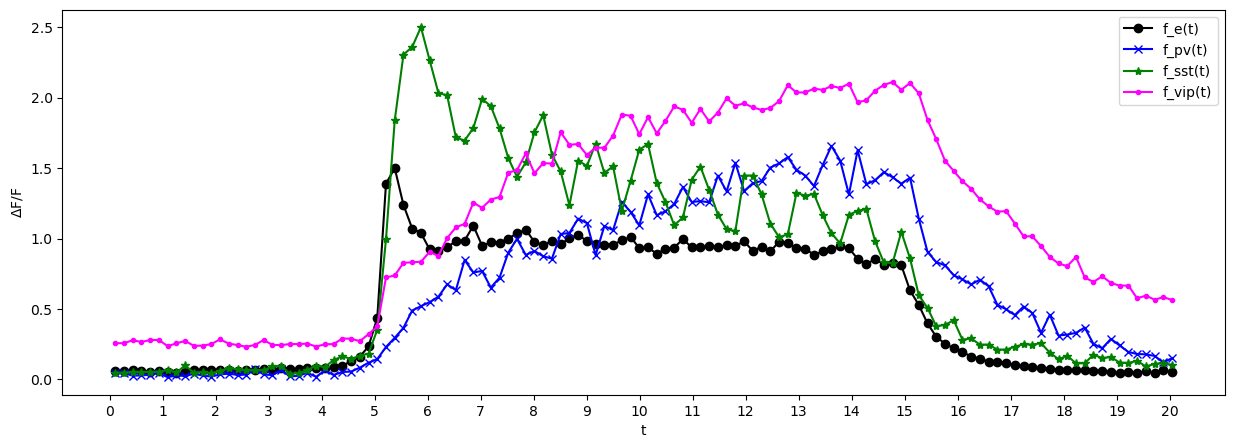

In [20]:
# time step
dt = 0.164745

# Inicialization of new arrays to cut traces for suitable range
t_exp_1_new = []
pv_new = []
sst_new = []
vip_new = []
pc_all_new = []
pc_all_err_new = []
pv_err_new = []
sst_err_new = []
vip_err_new = []
pc_opto_pv_arch_new = []
pc_opto_pv_chr_new = []
pc_opto_sst_chr_new = []
pc_opto_sst_arch_new = []


# Cutting the traces
for ind, time in np.ndenumerate(t_exp_1):
    if (time >= 5) and (time <= 25):
        t_exp_1_new.append(time - 5)
        pv_new.append(pv[ind])
        sst_new.append(sst[ind])
        vip_new.append(vip[ind])
        pc_all_new.append(pc_all[ind])
        pv_err_new.append(pv_err[ind])
        sst_err_new.append(sst_err[ind])
        vip_err_new.append(vip_err[ind])
        pc_opto_pv_arch_new.append(pc_opto_pv_arch[ind])
        pc_opto_pv_chr_new.append(pc_opto_pv_chr[ind])
        pc_opto_sst_chr_new.append(pc_opto_sst_chr[ind])
        pc_opto_sst_arch_new.append(pc_opto_sst_arch[ind])
        pc_all_err_new.append(pc_all_err[ind])
        
# Adjusting for a missing initial point after deconvolution        
pv_new.insert(0, pv_new[0])
sst_new.insert(0, sst_new[0])
vip_new.insert(0, vip_new[0])
pc_all_new.insert(0, pc_all_new[0])
pv_err_new.insert(0, pv_err_new[0])
sst_err_new.insert(0, sst_err_new[0])
vip_err_new.insert(0, vip_err_new[0])
pc_opto_pv_arch_new.insert(0, pc_opto_pv_arch_new[0])
pc_opto_pv_chr_new.insert(0, pc_opto_pv_chr_new[0])
pc_opto_sst_chr_new.insert(0, pc_opto_sst_chr_new[0])
pc_opto_sst_arch_new.insert(0, pc_opto_sst_arch_new[0])
pc_all_err_new.insert(0, pc_all_err_new[0])

t_exp_1_new.append(t_exp_1_new[-1] + dt)

# Plot traces
plt.figure(figsize=(15,5))
plt.plot(t_exp_1_new, pc_all_new, color='black', marker='o', label='f_e(t)')
plt.plot(t_exp_1_new, pv_new, color='blue', marker='x', label='f_pv(t)')
plt.plot(t_exp_1_new, sst_new, color='green', marker='*', label='f_sst(t)')
plt.plot(t_exp_1_new, vip_new, color='magenta', marker='.', label='f_vip(t)')

plt.legend(loc='best')
plt.ylabel(r'$\Delta$F/F')
plt.xlabel('t')
plt.xlim()
plt.xticks(np.arange(0,21,1))
plt.show()

# Variables and constants

In [21]:
# This cell to set initial parameters and working parameters

t = np.float32(np.array(t_exp_1_new))
t_exp = t
threshold = np.float32(0) 

power = np.float32(2.0)
q = np.float32(1.0)

ampl_1 = 1.0

r_1 = np.float32(1.75749763)
delay_1 = np.float32(0.21187243)
delay_2 = np.float32(1.62946084)
delay_3 = np.float32(0.37943295)
decay = np.float32(3.54582748)
decay_s = np.float32(0.26803051)
decay_ff = np.float32(1.70211256)
ampl = np.float32(1.0)
base = np.float32(1.0)
base_sigm = np.float32(0)

init = np.float32(np.array([0.055, 0.011, 0.017, 0.208, 0.055, 0.011, 0.017, 0.208]))
tau = np.float32(np.array([0.015, 0.0075, 0.019, 0.019]))
i = np.float32(np.array([0.25435776, 0.01401103, 0.02927017, 0.51027863]))
w = np.float32(np.array([
              0.06505351, # w_0  PC  -> PC        
              1.51655472, # w_1  FF  -> PC
              1.69971246, # w_2  SM   -> PC
              1.82141607, # w_3  PV -> PC
              0.62042205, # w_4  SST  -> PC
              0.19477673, # w_5  PC   -> PV
              0.57560143, # w_6  FF  -> PV
              2.09399360, # w_7  SM -> PV
              1.21895771, # w_8  PV   -> PV
              0.30590661, # w_9  SST  -> PV
              1.01472044, # w_10 PC -> SST
              0.59759942, # w_11 FB  -> SST
              0.22494105, # w_12 VIP  -> SST
              0.08938278, # w_13 PC  -> VIP
              0.00220557, # w_14 SST  -> VIP
              0.84651798, # w_15 SM  -> VIP
              0.74333759, # w_16 FB  -> PC
              0.43693422, # w_17 FB  -> PV
              0.02007970]))# w_18 FB -> VIP


data_pv = np.float32(np.array(pv_new)) 
data_sst = np.float32(np.array(sst_new)) 
data_vip = np.float32(np.array(vip_new)) 
data_pc_all = np.float32(np.array(pc_all_new))

data_pc_opto_pv_arch = np.float32(np.array(pc_opto_pv_arch_new))
data_pc_opto_pv_chr = np.float32(np.array(pc_opto_pv_chr_new))
data_pc_opto_sst_chr = np.float32(np.array(pc_opto_sst_chr_new))
data_pc_opto_sst_arch = np.float32(np.array(pc_opto_sst_arch_new))

pc_all_err_new = np.array(pc_all_err_new)
pv_err_new = np.array(pv_err_new)
sst_err_new = np.array(sst_err_new)
vip_err_new = np.array(vip_err_new)

count = 0
max_nfev = 2000

In [22]:
print(len(data_pc_all))

122


## Parameters

In [23]:
"""
Setting lmfit.Parameters() object with all parameters for the model,
their initial values, ranges and boolean varaible wether to vary them or not during fitting
"""

params = Parameters()
params.add('w_0', value = w[0] , vary = True, min = 0.0, max = 15)
params.add('w_1', value = w[1] , vary = True, min = 0.0, max = 15)
params.add('w_2', value = w[2] , vary = True, min = 0.0, max = 15)
params.add('w_3', value = w[3] , vary = True, min = 0.0, max = 15)
params.add('w_4', value = w[4] , vary = True, min = 0.0, max = 15)
params.add('w_5', value = w[5] , vary = True, min = 0.0, max = 15)
params.add('w_6', value = w[6] , vary = True, min = 0.0, max = 15)
params.add('w_7', value = w[7] , vary = True, min = 0.0, max = 15)
params.add('w_8', value = w[8] , vary = True, min = 0.0, max = 15)
params.add('w_9', value = w[9] , vary = True, min = 0.0, max = 15)
params.add('w_10', value = w[10] , vary = True, min = 0.0, max = 15)
params.add('w_11', value = w[11] , vary = True, min = 0.0, max = 15)
params.add('w_12', value = w[12] , vary = True, min = 0.0, max = 15)
params.add('w_13', value = w[13] , vary = True, min = 0.0, max = 15)
params.add('w_14', value = w[14] , vary = True, min = 0.0, max = 15)
params.add('w_15', value = w[15] , vary = True, min = 0.0, max = 15)
params.add('w_16', value = w[16] , vary = True, min = 0.0, max = 15)
params.add('w_17', value = w[17] , vary = True, min = 0.0, max = 15)
params.add('w_18', value = w[18] , vary = True, min = 0.0, max = 15)
params.add('tau_0', value = tau[0] , vary = False, min = 0.001, max = 0.03)
params.add('tau_1', value = tau[1] , vary = False, min = 0.001, max = 0.03)
params.add('tau_2', value = tau[2] , vary = False, min = 0.001, max = 0.03)
params.add('tau_3', value = tau[3] , vary = False, min = 0.001, max = 0.03)
params.add('threshold', value = threshold , vary = False, min = -np.inf, max = np.inf)
params.add('power', value = power , vary = False, min = 0.5, max = 2.5)
params.add('q', value = q, vary = False, min = 0.001, max = 2.5 )
params.add('i_0', value = i[0] , vary = True, min = 0.0, max = 0.7)
params.add('i_1', value = i[1] , vary = True, min = 0.0, max = 0.7)
params.add('i_2', value = i[2] , vary = True, min = 0.0, max = 0.7)
params.add('i_3', value = i[3] , vary = True, min = 0.0, max = 0.7)
params.add('ampl_1', value = ampl_1 , vary = False, min = 0.8, max = 1.5)
params.add('r_1', value = r_1, vary = True, min = 0, max = 5)
params.add('delay_1', value = delay_1, vary = True, min = 0, max = 1.5)
params.add('delay_2', value = delay_2, vary = True, min = 0, max = 25)
params.add('delay_3', value = delay_3, vary = True, min = 0, max = 3)
params.add('decay', value = decay, vary = True, min = 0, max = 10)
params.add('decay_s', value = decay_s, vary = True, min = 0, max = 10)
params.add('decay_ff', value = decay_ff, vary = True, min = 0, max = 10)
params.add('ampl', value = ampl, vary = False, min = 0, max = 5)
params.add('base', value = base, vary = False, min = 0, max = 5)
params.add('base_sigm', value = base_sigm, vary = False, min = 0, max = 2)
params

name,value,initial value,min,max,vary
w_0,0.06505351,0.06505350768566132,0.00000000,15.0000000,True
w_1,1.51655471,1.5165547132492065,0.00000000,15.0000000,True
w_2,1.69971251,1.6997125148773193,0.00000000,15.0000000,True
w_3,1.82141602,1.8214160203933716,0.00000000,15.0000000,True
w_4,0.62042207,0.6204220652580261,0.00000000,15.0000000,True
w_5,0.19477673,0.1947767287492752,0.00000000,15.0000000,True
w_6,0.57560146,0.5756014585494995,0.00000000,15.0000000,True
w_7,2.09399366,2.093993663787842,0.00000000,15.0000000,True
w_8,1.21895766,1.2189576625823975,0.00000000,15.0000000,True
w_9,0.30590662,0.30590662360191345,0.00000000,15.0000000,True


In [24]:
print(len(t_exp), t_exp)

122 [ 0.107095  0.27184   0.436585  0.60133   0.766075  0.93082   1.095565
  1.26031   1.425055  1.5898    1.754545  1.91929   2.084035  2.24878
  2.413525  2.57827   2.743015  2.90776   3.072505  3.23725   3.401995
  3.56674   3.731485  3.89623   4.060975  4.22572   4.390465  4.55521
  4.719955  4.8847    5.049445  5.21419   5.378935  5.54368   5.708425
  5.87317   6.037915  6.20266   6.367405  6.53215   6.696895  6.86164
  7.026385  7.19113   7.355875  7.52062   7.685365  7.85011   8.014855
  8.1796    8.344345  8.50909   8.673835  8.83858   9.003325  9.16807
  9.332815  9.49756   9.662305  9.82705   9.991795 10.15654  10.321285
 10.48603  10.650775 10.81552  10.980265 11.14501  11.309755 11.4745
 11.639245 11.80399  11.968735 12.13348  12.298225 12.46297  12.627715
 12.79246  12.957205 13.12195  13.286695 13.45144  13.616185 13.78093
 13.945675 14.11042  14.275165 14.43991  14.604655 14.7694   14.934145
 15.09889  15.263635 15.42838  15.593125 15.75787  15.922615 16.08736
 16.252106

In [25]:
# Slider feature. Could be ommited if slider wont be used.

w_0 = params['w_0'].value
w_1 = params['w_1'].value
w_2 = params['w_2'].value
w_3 = params['w_3'].value
w_4 = params['w_4'].value
w_5 = params['w_5'].value
w_6 = params['w_6'].value
w_7 = params['w_7'].value
w_8 = params['w_8'].value
w_9 = params['w_9'].value
w_10 = params['w_10'].value
w_11 = params['w_11'].value
w_12 = params['w_12'].value
w_13 = params['w_13'].value
w_14 = params['w_14'].value
w_15 = params['w_15'].value
w_16 = params['w_16'].value
w_17 = params['w_17'].value
w_18 = params['w_18'].value
tau_0 = params['tau_0'].value
tau_1 = params['tau_1'].value
tau_2 = params['tau_2'].value
tau_3 = params['tau_3'].value
threshold = params['threshold'].value
power = params['power'].value
q = params['q'].value
i_0 = params['i_0'].value
i_1 = params['i_1'].value
i_2 = params['i_2'].value
i_3 = params['i_3'].value
ampl_1 = params['ampl_1'].value
r_1 = params['r_1'].value
delay_1 = params['delay_1'].value
delay_2 = params['delay_2'].value
delay_3 = params['delay_3'].value
decay = params['decay'].value
decay_s = params['decay_s'].value
decay_ff = params['decay_ff'].value
ampl = params['ampl'].value
base = params['base'].value
base_sigm = params['base_sigm'].value

In [26]:
# Slider feature. Could be ommited if slider wont be used. Set widget.FloatSlider() insted fixed() to add parameter to slider.

%matplotlib inline
from ipywidgets import interactive, fixed
import ipywidgets as widgets
interactive(slider, 
            w_0 = fixed(w_0), 
            w_1=fixed(w_1), w_2=fixed(w_2), w_3=widgets.FloatSlider(min=0, max=5, step=0.1, value=w_3), w_4=widgets.FloatSlider(min=0, max=7, step=0.1, value=w_4), w_5=fixed(w_5), 
            w_6=fixed(w_6), w_7=widgets.FloatSlider(min=0, max=3, step=0.1, value=w_7), w_8=fixed(w_8), w_9=fixed(w_9), w_10=fixed(w_10), 
            w_11=fixed(w_11), w_12=fixed(w_12), w_13=fixed(w_13), w_14=fixed(w_14), w_15=fixed(w_15), 
            w_16=fixed(w_16), w_17=fixed(w_17), w_18=fixed(w_18), 
            tau_0=fixed(tau_0), tau_1=fixed(tau_1), tau_2=fixed(tau_2), tau_3=fixed(tau_3),
            threshold=fixed(threshold), power=fixed(power), q=fixed(q),
            i_0=fixed(i_0), i_1=fixed(i_1), i_2=fixed(i_2), i_3=fixed(i_3),
            r_1=fixed(r_1), decay=fixed(decay), delay_1=fixed(delay_1), delay_2=fixed(delay_2), delay_3=fixed(delay_3), ampl=fixed(ampl),
            base=fixed(base), decay_s=fixed(decay_s), ampl_1=fixed(ampl_1), base_sigm=fixed(base_sigm), decay_ff=fixed(decay_ff))

interactive(children=(FloatSlider(value=1.8214160203933716, description='w_3', max=5.0), FloatSlider(value=0.6…

In [27]:
# Simulate a model with parameters defimed in params

model = simulate_step(t_exp, init, params)

In [28]:
# Write csv file with output
# model[['t', 'f_e_o']].to_csv('out_sst_chr_2024-11-06.csv', index=False)

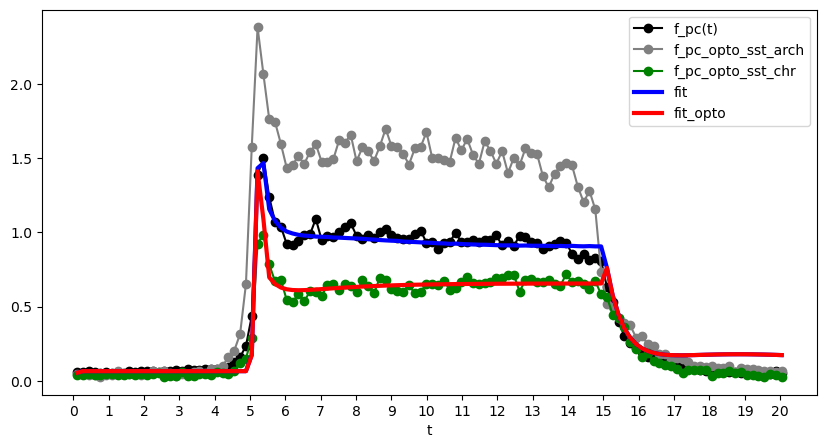

In [29]:
# Plot model against PC_average data and model with optogenetic against opto data. Non required opto are commented out.
# In a current version optogenetic predictions realised through the simulation from initial parameters.
# This means that after fitting one needs to update initial parameters with fitted and check opto predictions.
# Opto manipulation is in the function, where system of equations is described.

plt.figure(figsize=(10,5))
plt.plot(t_exp, pc_all_new, color='black', marker='o', label='f_pc(t)')

plt.plot(t_exp, data_pc_opto_sst_arch, color='gray', marker='o', label='f_pc_opto_sst_arch')
plt.plot(t_exp, data_pc_opto_sst_chr, color='green', marker='o', label='f_pc_opto_sst_chr')
#plt.plot(t_exp, data_pc_opto_pv_arch, color='gray', marker='o', label='f_pc_opto_pv_arch')
#plt.plot(t_exp, data_pc_opto_pv_chr, color='green', marker='o', label='f_pc_opto_pv_chr')

plt.plot(t_exp, model['f_e'].values, color='blue', label='fit', linewidth=3)
plt.plot(t_exp, model['f_e_o'].values, color='red', label='fit_opto', linewidth=3)

plt.legend(loc='best')
plt.xlabel('t')
#plt.ylim(0, 1.6)
plt.xticks(np.arange(0,21,1))

plt.show()

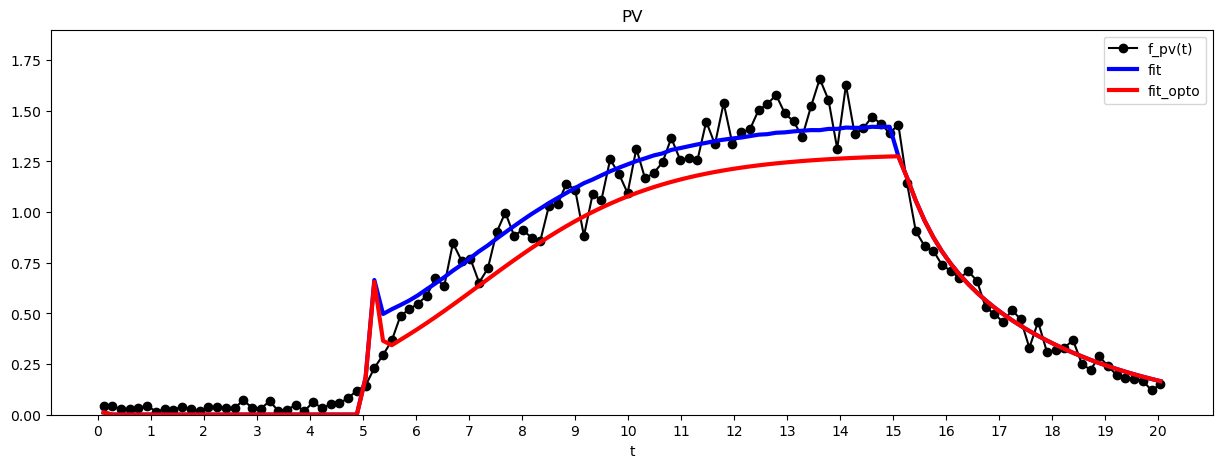

In [30]:
# PV data, model and opto effect

plt.figure(figsize=(15,5))

plt.plot(t_exp, data_pv, color='black', marker='o', label='f_pv(t)')

plt.plot(t_exp, model['f_pv'].values, color='blue', label='fit', linewidth=3)
plt.plot(t_exp, model['f_pv_o'].values, color='red', label='fit_opto', linewidth=3)

plt.title('PV')
plt.legend(loc='best')
plt.xlabel('t')
plt.ylim(0, 1.9)
plt.xticks(np.arange(0,21,1))

plt.show()

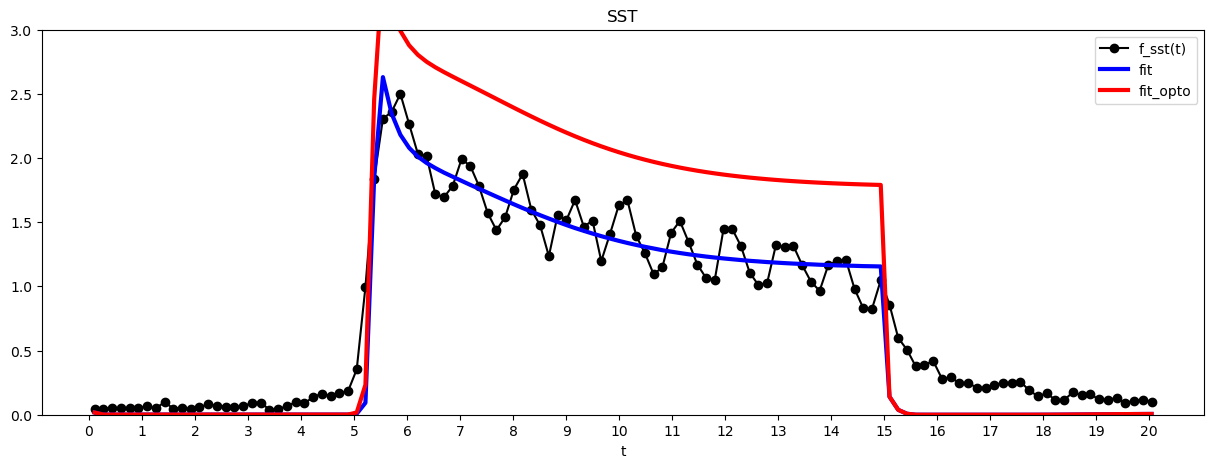

In [31]:
# SST data, model and opto effect

plt.figure(figsize=(15,5))
plt.plot(t_exp, data_sst, color='black', marker='o', label='f_sst(t)')
plt.plot(t_exp, model['f_sst'].values, color='blue', label='fit', linewidth=3)
plt.plot(t_exp, model['f_sst_o'].values, color='red', label='fit_opto', linewidth=3)

plt.title('SST')
plt.legend(loc='best')
plt.xlabel('t')
plt.ylim(0, 3.0)
plt.xticks(np.arange(0,21,1))

plt.show()

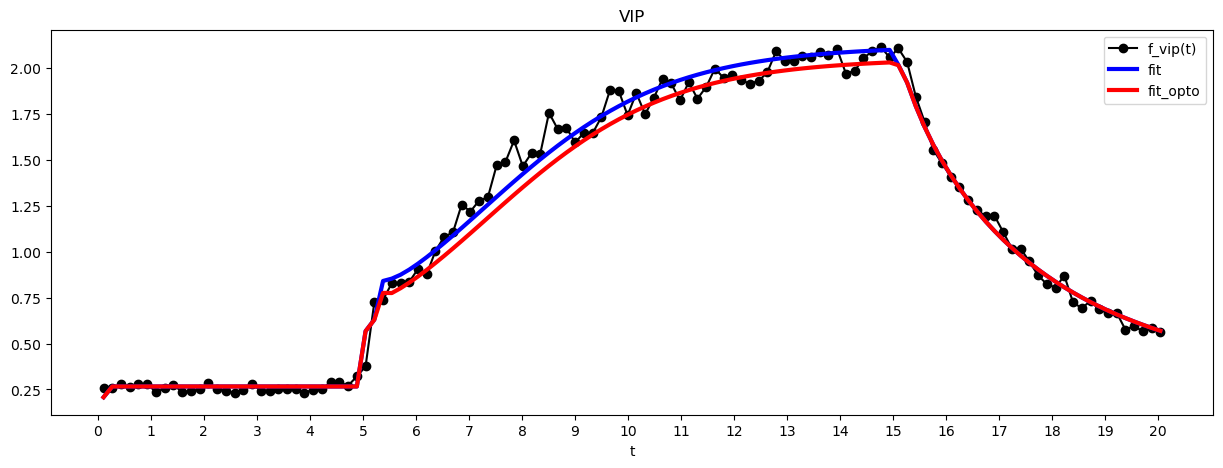

In [32]:
# VIP data, model and opto effect


plt.figure(figsize=(15,5))
plt.plot(t_exp, data_vip, color='black', marker='o', label='f_vip(t)')
plt.plot(t_exp, model['f_vip'].values, color='blue', label='fit', linewidth=3)
plt.plot(t_exp, model['f_vip_o'].values, color='red', label='fit_opto', linewidth=3)

plt.title('VIP')
plt.legend(loc='best')
plt.xlabel('t')
#plt.ylim(0, 2.2)
plt.xticks(np.arange(0,21,1))

plt.show()

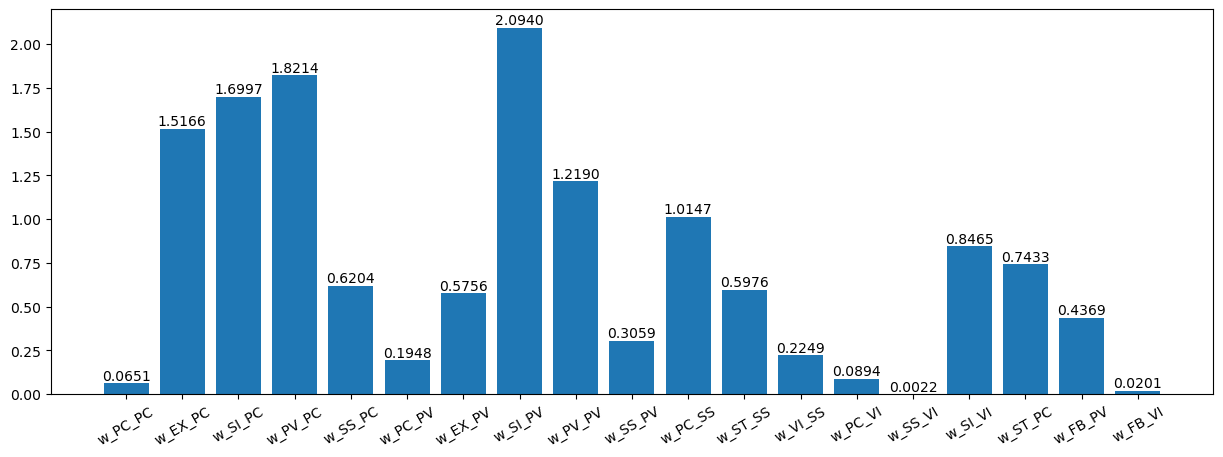

In [33]:
# Bar plot visualization of all weights

vals = []
for _, param in params.items():
    vals.append(param.value)
    
plt.figure(figsize=(15,5))
plt.bar(range(len(vals[:19])),vals[:19], color='blue')
plt.xticks(range(len(vals[:19])), names[:19], rotation = 30)
plt.bar_label(plt.bar(range(len(vals[:19])),vals[:19]), fmt = '{:.4f}')
plt.show()

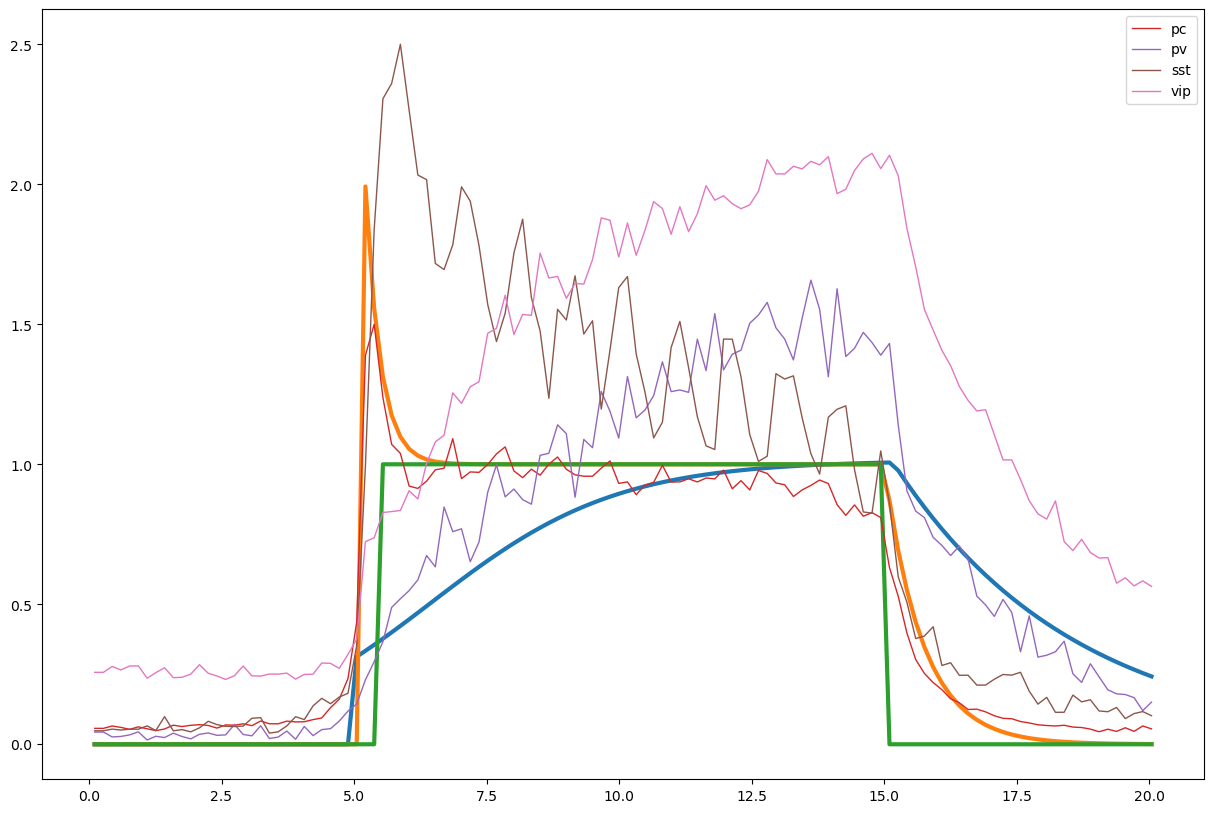

In [34]:
# Visualization of population traces and inputs

sig = []
ex = []
st = []
for i in t_exp:
    sig.append(Sigm(i, ampl = 1.01359931, rate = 1.75139660, delay = 1.45963700, decay_s = 0.29203316, base = 0))
    ex.append(expon(i, ampl = ampl, base = 1, decay = 3.51342590, delay = 0.21200599, decay_ff = 1.39646321))
    st.append(Step(i, k = 0, delay = 0.41140712))
    
plt.figure(figsize = (15,10))
plt.plot(t_exp, np.array(sig), linewidth = 3)
plt.plot(t_exp, np.array(ex), linewidth = 3)
plt.plot(t_exp, np.array(st), linewidth = 3)
plt.plot(t_exp, data_pc_all, label = 'pc', linewidth = 1)
plt.plot(t_exp, data_pv, label = 'pv', linewidth = 1)
plt.plot(t_exp, data_sst, label = 'sst', linewidth = 1)
plt.plot(t_exp, data_vip, label = 'vip', linewidth = 1)
plt.legend()
#plt.xlim(4.5, 5.5)
plt.show()

In [35]:
# Writing down inputs to pandas.DataFrame

inp = pd.DataFrame()
inp['t'] = t_exp
inp['FF'] = ex
inp['SM'] = sig
inp['FB'] = st
inp

,t,FF,SM,FB
0,0.107095,0.000000,0.000000,0.0
1,0.271840,0.000000,0.000000,0.0
2,0.436585,0.000000,0.000000,0.0
3,0.601330,0.000000,0.000000,0.0
4,0.766075,0.000000,0.000000,0.0
...,...,...,...,...
117,19.382259,0.002199,0.293739,0.0
118,19.547005,0.001747,0.279942,0.0
119,19.711750,0.001388,0.266792,0.0
120,19.876495,0.001103,0.254260,0.0


In [36]:
# Used to save inputs to csv file
# inp[['t', 'FF', 'SM', 'FB']].to_csv('out_inputs.csv', index=False)

# Fitting model to a data with different algorithms

## leastsq (Levenberg-Marquardt)

In [37]:
count = 0

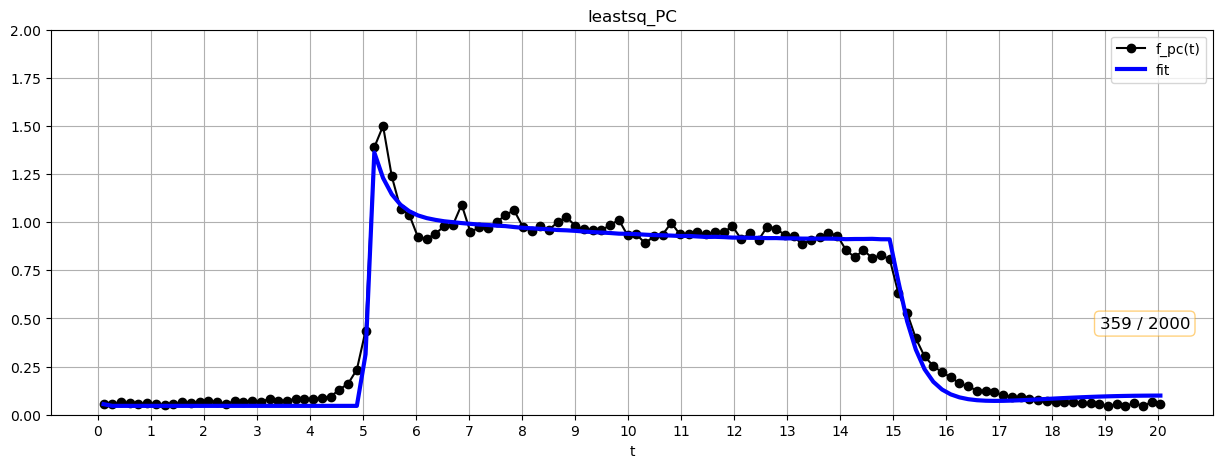


CPU times: total: 3min 39s
Wall time: 3min 41s


In [38]:
%%time
%matplotlib inline

result_leastsq = minimize(residual_step, params, method='least_squares', args=(t_exp, init, data_pc_all, data_pv, data_sst, data_vip), nan_policy='propagate', max_nfev=3*max_nfev, ftol=1e-15, gtol=1e-15, xtol=1e-15)
print()


In [39]:
report_fit(result_leastsq)

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 359
    # data points      = 488
    # variables        = 30
    chi-square         = 3623.97900
    reduced chi-square = 7.91261790
    Akaike info crit   = 1038.44608
    Bayesian info crit = 1164.15555
##  Warning: uncertainties could not be estimated:
[[Variables]]
    w_0:        0.04043094 (init = 0.06505351)
    w_1:        1.75288728 (init = 1.516555)
    w_2:        1.38471152 (init = 1.699713)
    w_3:        1.76234573 (init = 1.821416)
    w_4:        0.66040872 (init = 0.6204221)
    w_5:        0.18533598 (init = 0.1947767)
    w_6:        0.57964131 (init = 0.5756015)
    w_7:        2.04637970 (init = 2.093994)
    w_8:        1.24565273 (init = 1.218958)
    w_9:        0.30016802 (init = 0.3059066)
    w_10:       1.20222031 (init = 1.01472)
    w_11:       0.36807977 (init = 0.5975994)
    w_12:       0.21244270 (init = 0.224941)
    w_13:       0.07454890 (init = 0.08938278)
    w_14:

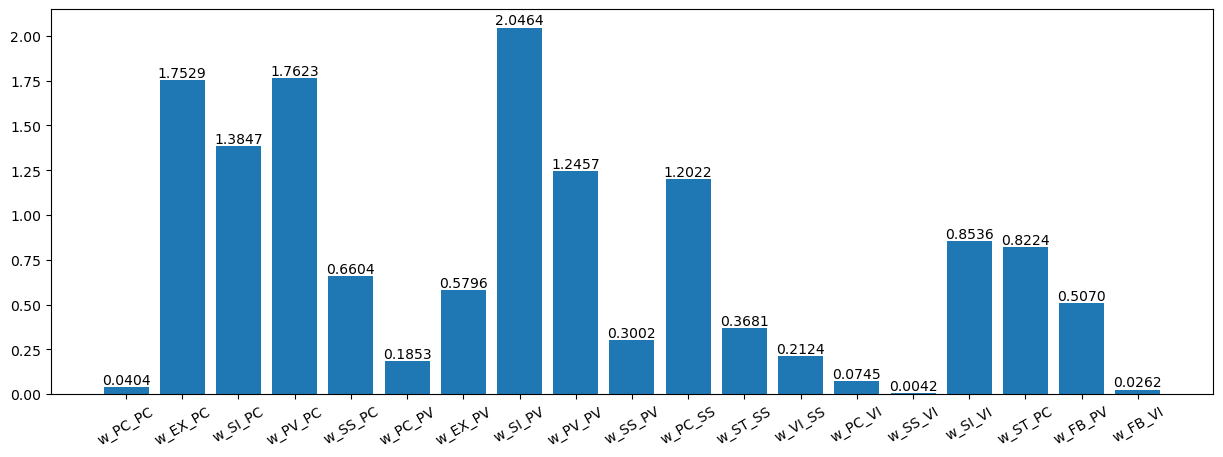

In [40]:
vals = []
for _, param in result_leastsq.params.items():
    vals.append(param.value)
    
plt.figure(figsize=(15,5))
plt.bar(range(len(vals[:19])),vals[:19], color='blue')
plt.xticks(range(len(vals[:19])), names[:19], rotation = 30)
plt.bar_label(plt.bar(range(len(vals[:19])),vals[:19]), fmt = '{:.4f}')
plt.show()

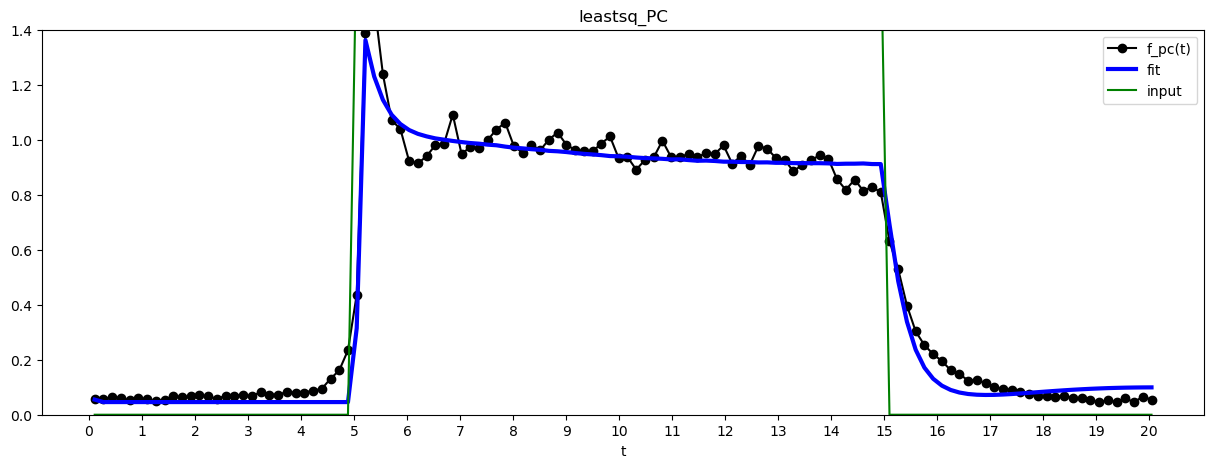

In [41]:
sim_leastsq = simulate_step(t_exp, init, params)
fit_leastsq = simulate_step(t_exp, init, result_leastsq.params)
step = []

for i in t_exp:
    step.append(Step(i))
    
curve = np.array(step) * result_leastsq.params['w_1'].value
    
plt.figure(figsize=(15,5))
plt.plot(t_exp, pc_all_new, color='black', marker='o', label='f_pc(t)')
plt.plot(t_exp, fit_leastsq['f_e'].values, color='blue', label='fit', linewidth=3)
# plt.plot(t_exp, sim_leastsq['f_e'].values, color='red', label='init_fit')
plt.plot(t_exp, curve, color = 'green', label='input')
plt.title('leastsq_PC')
plt.legend(loc='best')
plt.xlabel('t')
plt.ylim(0, 1.4)
plt.xticks(np.arange(0,21,1))
#plt.grid()
plt.show()

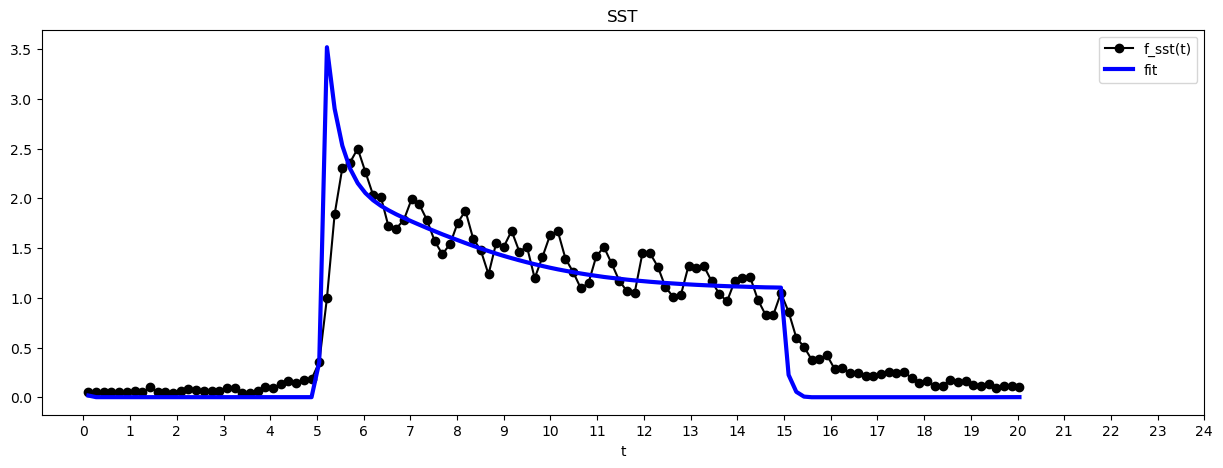

In [42]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_sst, color='black', marker='o', label='f_sst(t)')
plt.plot(t_exp, fit_leastsq['f_sst'].values, color='blue', label='fit', linewidth=3)
#plt.plot(t_exp, sim_leastsq['f_sst'].values, color='red', label='init_fit')
plt.title('SST')
plt.legend(loc='best')
plt.xlabel('t')
plt.xticks(np.arange(0,25,1))
#plt.grid()
plt.show()

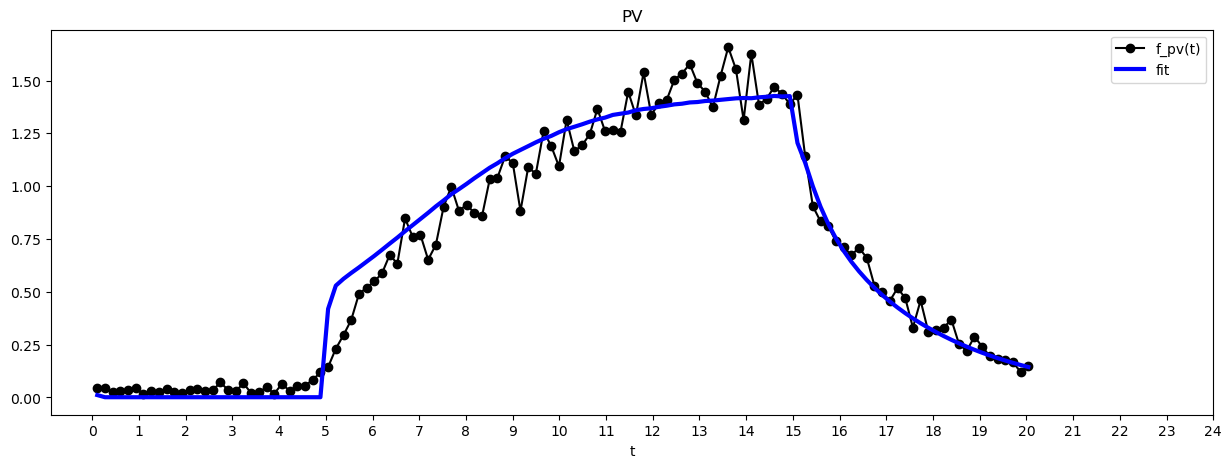

In [43]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_pv, color='black', marker='o', label='f_pv(t)')
plt.plot(t_exp, fit_leastsq['f_pv'].values, color='blue', label='fit', linewidth=3)
#plt.plot(t_exp, sim_leastsq['f_pv'].values, color='red', label='init_fit')
plt.title('PV')
plt.legend(loc='best')
plt.xlabel('t')
plt.xlim()
plt.xticks(np.arange(0,25,1))
#plt.grid()
plt.show()

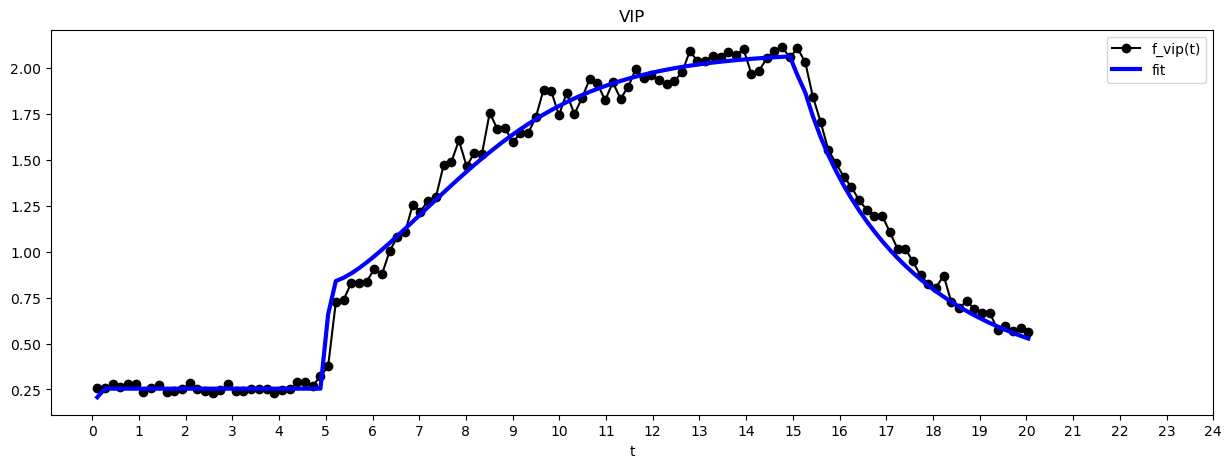

In [44]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_vip, color='black', marker='o', label='f_vip(t)')
plt.plot(t_exp, fit_leastsq['f_vip'].values, color='blue', label='fit', linewidth=3)
#plt.plot(t_exp, sim_leastsq['f_vip'].values, color='red', label='init_fit')
plt.title('VIP')
plt.legend(loc='best')
plt.xlabel('t')
plt.xlim()
plt.xticks(np.arange(0,25,1))
#plt.grid()
plt.show()

## least_squares

In [45]:
count = 0

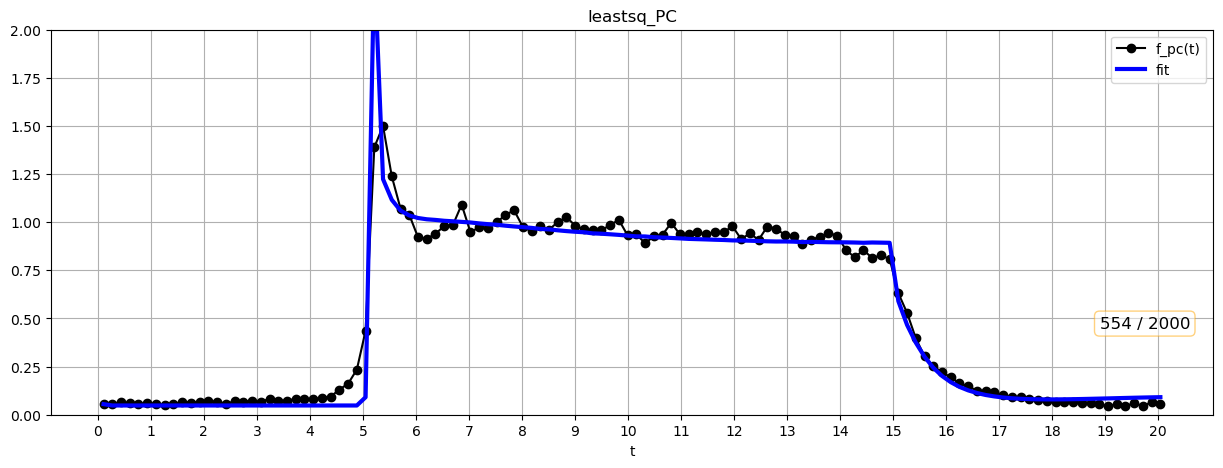


CPU times: total: 5min 50s
Wall time: 5min 52s


In [46]:
%%time
%matplotlib inline

result_leastsqs = minimize(residual_step, params, method='leastsq', args=(t_exp, init, data_pc_all, data_pv, data_sst, data_vip), nan_policy='propagate', max_nfev=3*max_nfev, ftol=1e-15, gtol=1e-15, xtol=1e-15)
print()


In [47]:
report_fit(result_leastsqs)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 552
    # data points      = 488
    # variables        = 30
    chi-square         = 2983.62054
    reduced chi-square = 6.51445533
    Akaike info crit   = 943.561763
    Bayesian info crit = 1069.27122
##  Warning: uncertainties could not be estimated:
[[Variables]]
    w_0:        0.03005853 (init = 0.06505351)
    w_1:        1.66359229 (init = 1.516555)
    w_2:        1.35429813 (init = 1.699713)
    w_3:        1.75343805 (init = 1.821416)
    w_4:        0.67202751 (init = 0.6204221)
    w_5:        0.19771493 (init = 0.1947767)
    w_6:        0.56764331 (init = 0.5756015)
    w_7:        2.11024459 (init = 2.093994)
    w_8:        1.21900022 (init = 1.218958)
    w_9:        0.29777663 (init = 0.3059066)
    w_10:       1.16467921 (init = 1.01472)
    w_11:       0.44147524 (init = 0.5975994)
    w_12:       0.22921368 (init = 0.224941)
    w_13:       0.12443274 (init = 0.08938278)
    w_14:      

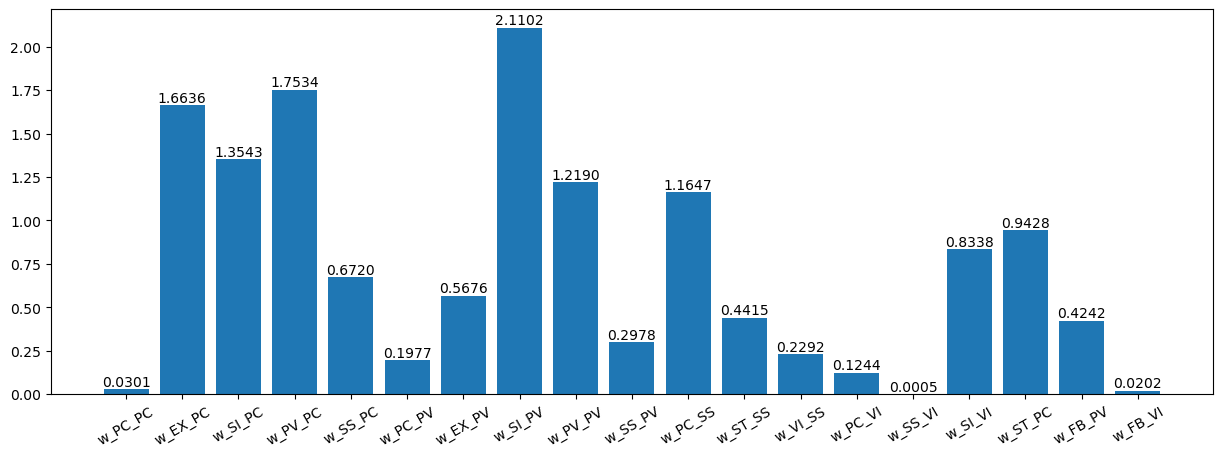

In [48]:
vals = []
for _, param in result_leastsqs.params.items():
    vals.append(param.value)
    
plt.figure(figsize=(15,5))
plt.bar(range(len(vals[:19])),vals[:19], color='blue')
plt.xticks(range(len(vals[:19])), names[:19], rotation = 30)
plt.bar_label(plt.bar(range(len(vals[:19])),vals[:19]), fmt = '{:.4f}')
plt.show()

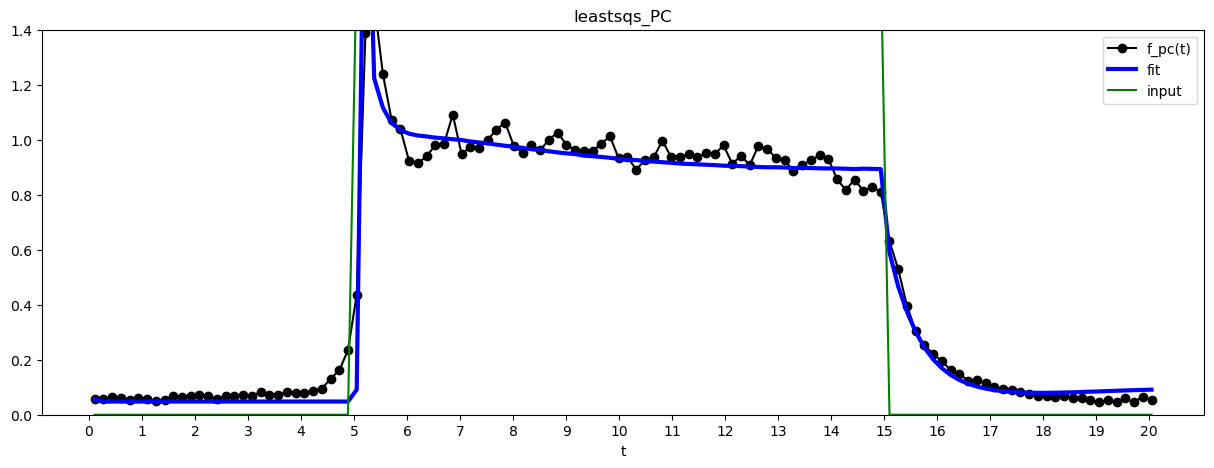

In [49]:
sim_leastsqs = simulate_step(t_exp, init, params)
fit_leastsqs = simulate_step(t_exp, init, result_leastsqs.params)
step = []

for i in t_exp:
    step.append(Step(i))
    
curve = np.array(step) * result_leastsqs.params['w_1'].value
    
plt.figure(figsize=(15,5))
plt.plot(t_exp, pc_all_new, color='black', marker='o', label='f_pc(t)')
plt.plot(t_exp, fit_leastsqs['f_e'].values, color='blue', label='fit', linewidth=3)
# plt.plot(t_exp, sim_leastsq['f_e'].values, color='red', label='init_fit')
plt.plot(t_exp, curve, color = 'green', label='input')
plt.title('leastsqs_PC')
plt.legend(loc='best')
plt.xlabel('t')
plt.ylim(0, 1.4)
plt.xticks(np.arange(0,21,1))
#plt.grid()
plt.show()

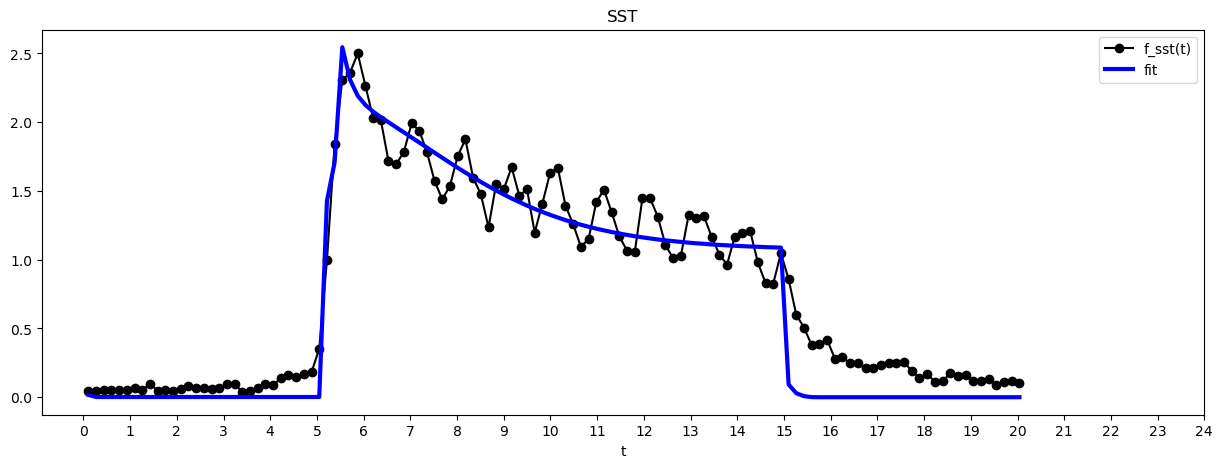

In [50]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_sst, color='black', marker='o', label='f_sst(t)')
plt.plot(t_exp, fit_leastsqs['f_sst'].values, color='blue', label='fit', linewidth=3)
#plt.plot(t_exp, sim_leastsq['f_sst'].values, color='red', label='init_fit')
plt.title('SST')
plt.legend(loc='best')
plt.xlabel('t')
plt.xticks(np.arange(0,25,1))
#plt.grid()
plt.show()

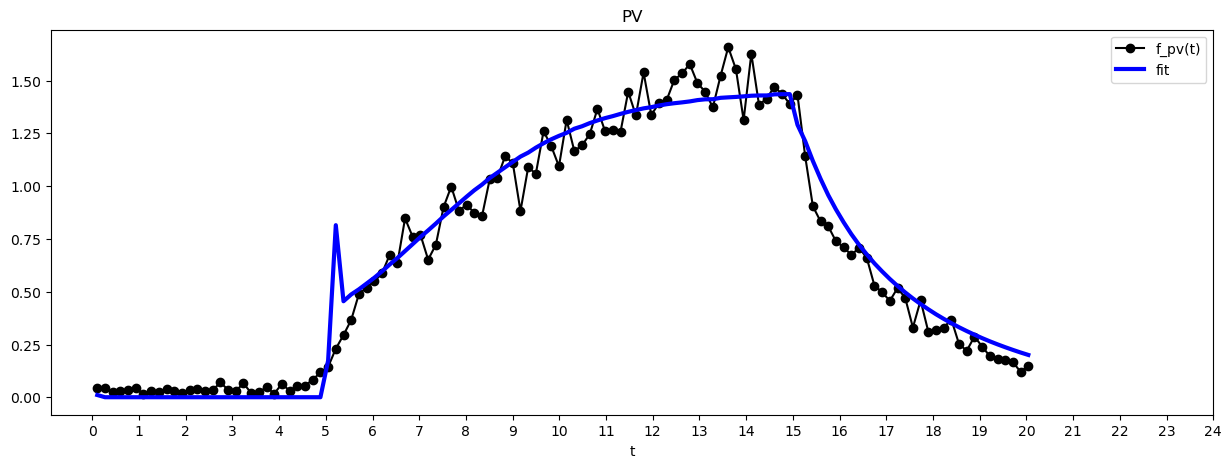

In [51]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_pv, color='black', marker='o', label='f_pv(t)')
plt.plot(t_exp, fit_leastsqs['f_pv'].values, color='blue', label='fit', linewidth=3)
#plt.plot(t_exp, sim_leastsq['f_pv'].values, color='red', label='init_fit')
plt.title('PV')
plt.legend(loc='best')
plt.xlabel('t')
plt.xlim()
plt.xticks(np.arange(0,25,1))
#plt.grid()
plt.show()

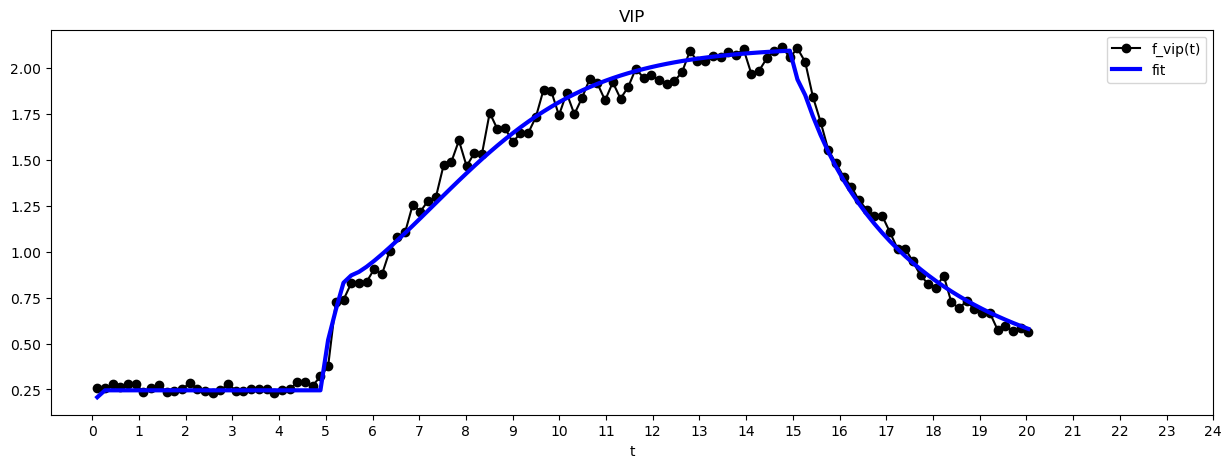

In [52]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_vip, color='black', marker='o', label='f_vip(t)')
plt.plot(t_exp, fit_leastsqs['f_vip'].values, color='blue', label='fit', linewidth=3)
#plt.plot(t_exp, sim_leastsq['f_vip'].values, color='red', label='init_fit')
plt.title('VIP')
plt.legend(loc='best')
plt.xlabel('t')
plt.xlim()
plt.xticks(np.arange(0,25,1))
#plt.grid()
plt.show()

## nelder

In [53]:
count = 0

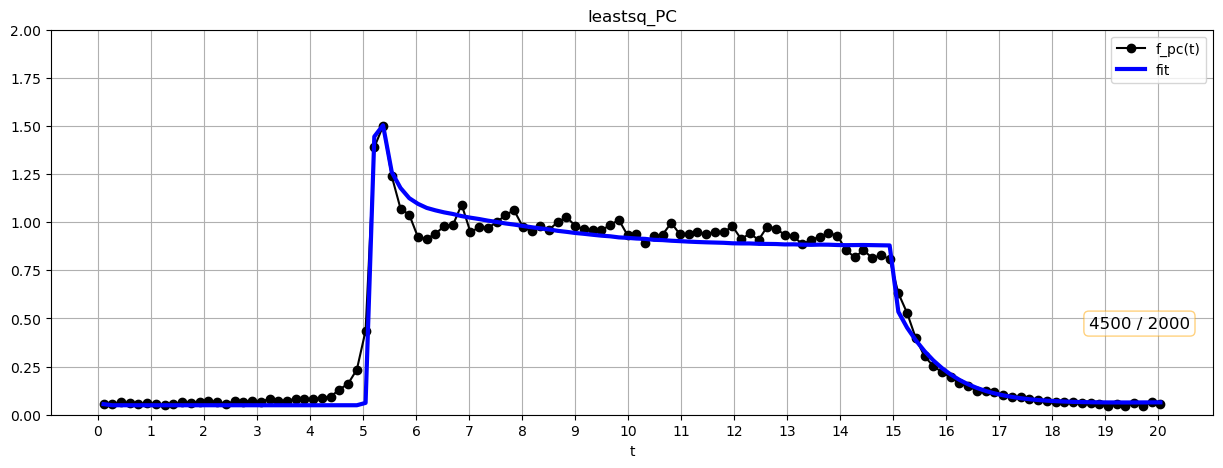


CPU times: total: 43min 8s
Wall time: 43min 21s


In [54]:
%%time

%matplotlib inline

result_nelder = minimize(residual_step, params, method='nelder', args=(t_exp, init, data_pc_all, data_pv, data_sst, data_vip), nan_policy='propagate', options = {'adaptive' : True}, max_nfev = 4500)
print()


In [55]:
report_fit(result_nelder)

[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 4501
    # data points      = 488
    # variables        = 30
    chi-square         = 2079.26132
    reduced chi-square = 4.53987189
    Akaike info crit   = 767.332855
    Bayesian info crit = 893.042317
##  Warning: uncertainties could not be estimated:
[[Variables]]
    w_0:        8.2109e-04 (init = 0.06505351)
    w_1:        2.07952328 (init = 1.516555)
    w_2:        1.05615989 (init = 1.699713)
    w_3:        1.91816606 (init = 1.821416)
    w_4:        0.81971933 (init = 0.6204221)
    w_5:        0.76640572 (init = 0.1947767)
    w_6:        0.55213768 (init = 0.5756015)
    w_7:        1.89495772 (init = 2.093994)
    w_8:        1.46618797 (init = 1.218958)
    w_9:        0.41811908 (init = 0.3059066)
    w_10:       1.14921224 (init = 1.01472)
    w_11:       0.01128321 (init = 0.5975994)
    w_12:       0.01471194 (init = 0.224941)
    w_13:       0.18866725 (init = 0.08938278)
    w_14: 

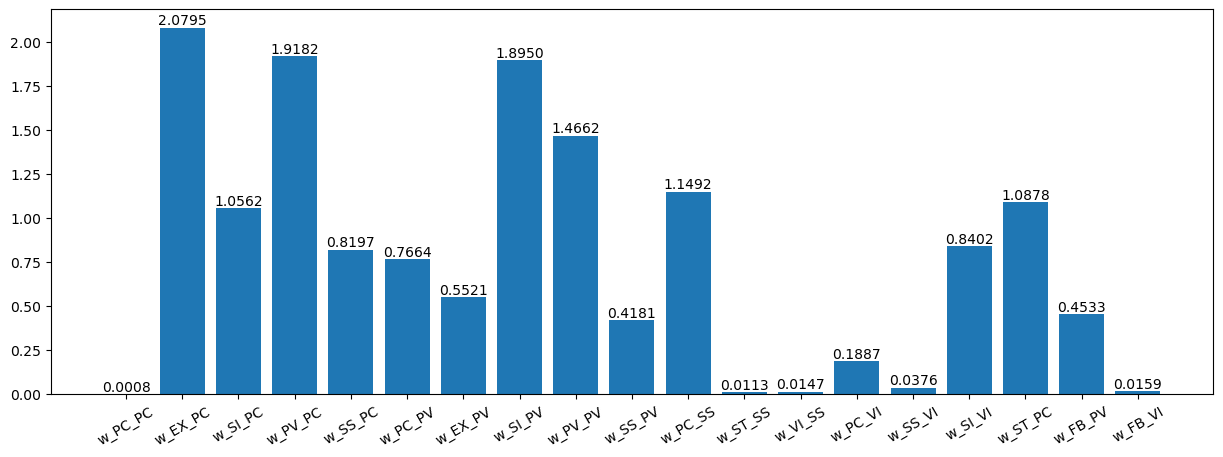

In [56]:
vals = []
for _, param in result_nelder.params.items():
    vals.append(param.value)
    
plt.figure(figsize=(15,5))
plt.bar(range(len(vals[:19])),vals[:19], color='blue')
plt.xticks(range(len(vals[:19])), names[:19], rotation = 30)
plt.bar_label(plt.bar(range(len(vals[:19])),vals[:19]), fmt = '{:.4f}')
plt.show()

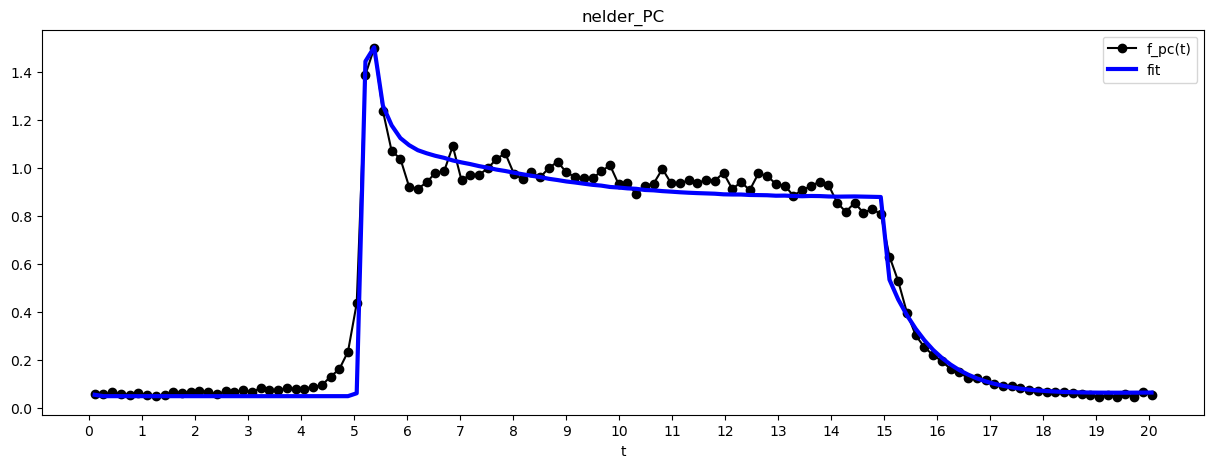

In [57]:
sim_nelder = simulate_step(t_exp, init, params)
fit_nelder = simulate_step(t_exp, init, result_nelder.params)
step_pv = []

plt.figure(figsize=(15,5))
plt.plot(t_exp, pc_all_new, color='black', marker='o', label='f_pc(t)')
plt.plot(t_exp, fit_nelder['f_e'].values, color='blue', label='fit', linewidth=3)

plt.title('nelder_PC')
plt.legend(loc='best')
plt.xlabel('t')
#plt.ylim(0, 5)
plt.xticks(np.arange(0,21,1))

plt.show()

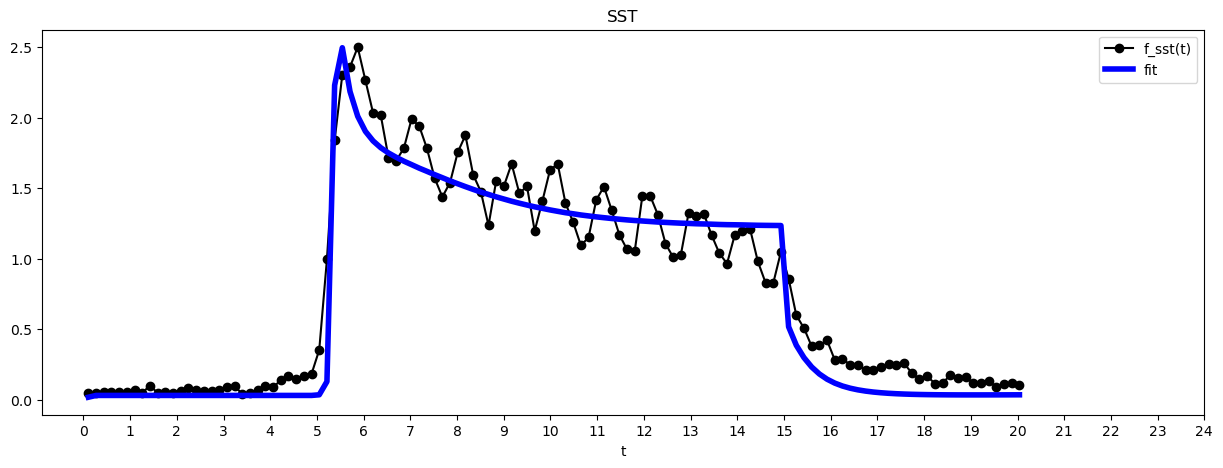

In [58]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_sst, color='black', marker='o', label='f_sst(t)')
plt.plot(t_exp, fit_nelder['f_sst'].values, color='blue', label='fit', linewidth=4)

plt.title('SST')
plt.legend(loc='best')
plt.xlabel('t')
plt.xlim()
plt.ylim()
plt.xticks(np.arange(0,25,1))
#plt.grid()
plt.show()

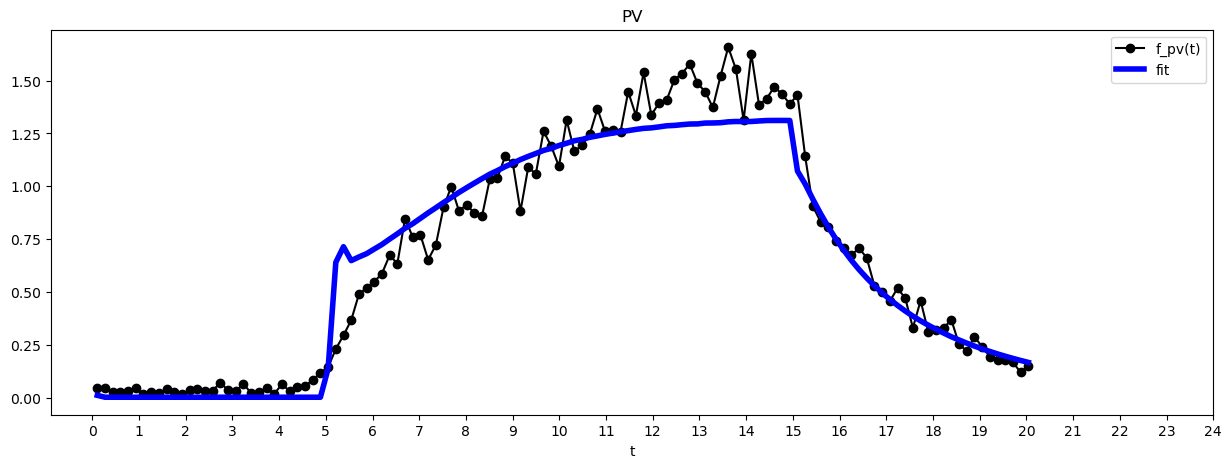

In [59]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_pv, color='black', marker='o', label='f_pv(t)')
plt.plot(t_exp, fit_nelder['f_pv'].values, color='blue', label='fit', linewidth=4)

plt.title('PV')
plt.legend(loc='best')
plt.xlabel('t')
plt.xlim()
plt.xticks(np.arange(0,25,1))
#plt.grid()
plt.show()

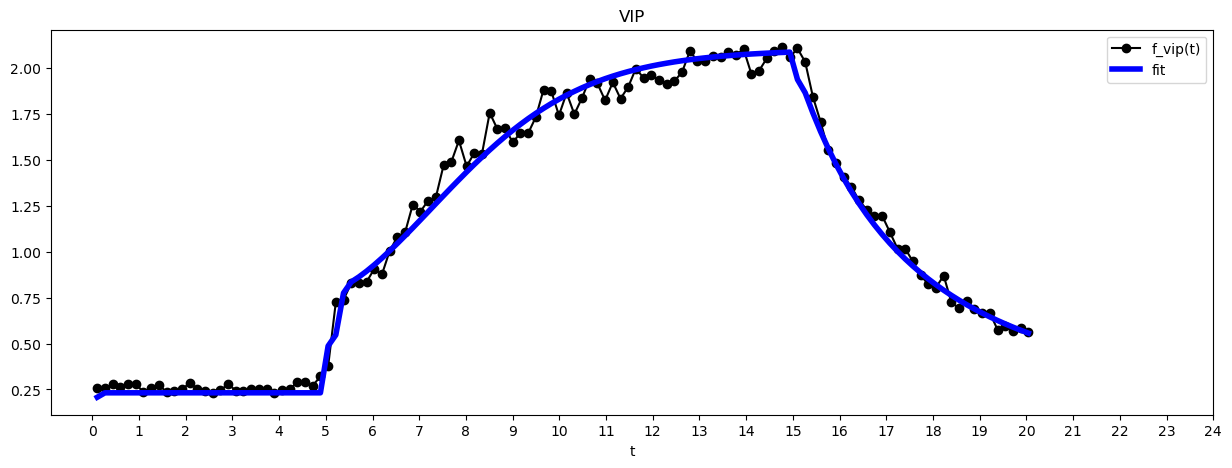

In [60]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_vip, color='black', marker='o', label='f_vip(t)')
plt.plot(t_exp, fit_nelder['f_vip'].values, color='blue', label='fit', linewidth=4)

plt.title('VIP')
plt.legend(loc='best')
plt.xlabel('t')
plt.xlim()
plt.xticks(np.arange(0,25,1))
#plt.grid()
plt.show()

In [61]:
model_opto = simulate_step(t_exp, init, result_nelder.params)

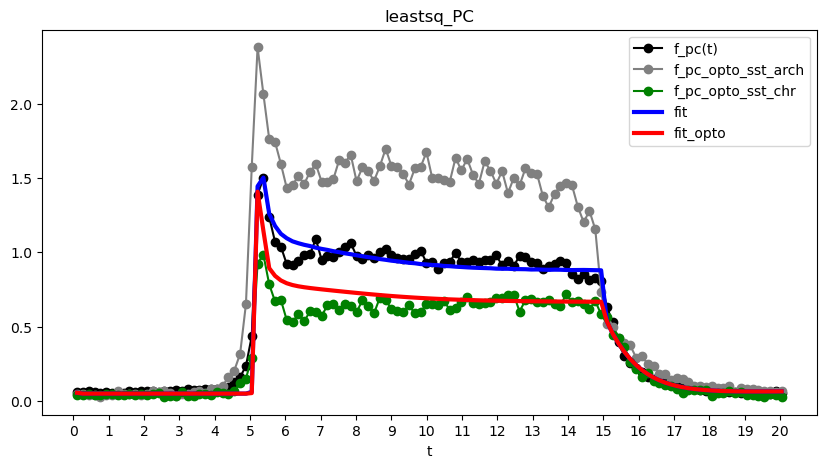

In [62]:
plt.figure(figsize=(10,5))
plt.plot(t_exp, pc_all_new, color='black', marker='o', label='f_pc(t)')

plt.plot(t_exp, data_pc_opto_sst_arch, color='gray', marker='o', label='f_pc_opto_sst_arch')
plt.plot(t_exp, data_pc_opto_sst_chr, color='green', marker='o', label='f_pc_opto_sst_chr')
plt.plot(t_exp, model_opto['f_e'].values, color='blue', label='fit', linewidth=3)
plt.plot(t_exp, model_opto['f_e_o'].values, color='red', label='fit_opto', linewidth=3)

plt.title('leastsq_PC')
plt.legend(loc='best')
plt.xlabel('t')
#plt.ylim(0, 1.6)
plt.xticks(np.arange(0,21,1))
#plt.xlim(3,7)

plt.show()

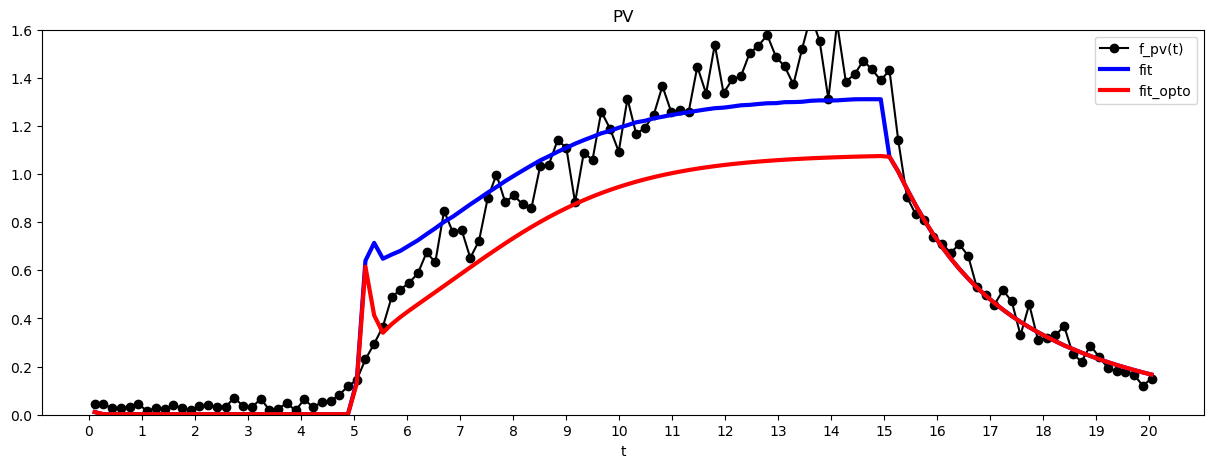

In [63]:
plt.figure(figsize=(15,5))
fast = []
slow = []
for i in t_exp:
    fast.append(0.33181904 * expon(i, ampl = 2.21679020, base = 2.8, decay = 2.86514393, delay = 0.02399650))
    slow.append(0.62204067 * Sigm(i, rate = 1.46386253, delay = 2.37599864))

plt.plot(t_exp, data_pv, color='black', marker='o', label='f_pv(t)')

plt.plot(t_exp, model_opto['f_pv'].values, color='blue', label='fit', linewidth=3)
plt.plot(t_exp, model_opto['f_pv_o'].values, color='red', label='fit_opto', linewidth=3)

plt.title('PV')
plt.legend(loc='best')
plt.xlabel('t')
plt.ylim(0, 1.6)
plt.xticks(np.arange(0,21,1))

plt.show()

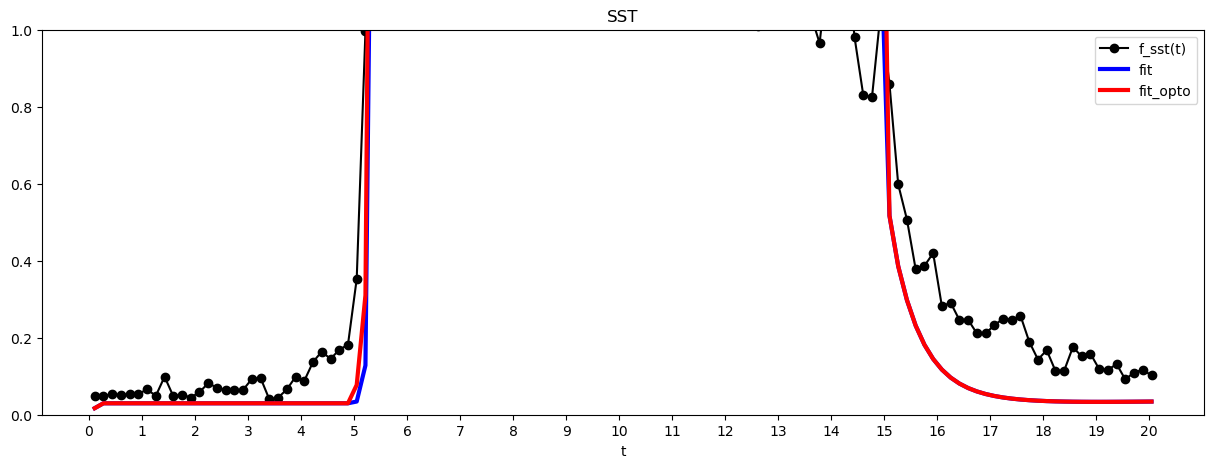

In [64]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_sst, color='black', marker='o', label='f_sst(t)')
plt.plot(t_exp, model_opto['f_sst'].values, color='blue', label='fit', linewidth=3)
plt.plot(t_exp, model_opto['f_sst_o'].values, color='red', label='fit_opto', linewidth=3)

plt.title('SST')
plt.legend(loc='best')
plt.xlabel('t')
plt.ylim(0, 1.0)
plt.xticks(np.arange(0,21,1))

plt.show()

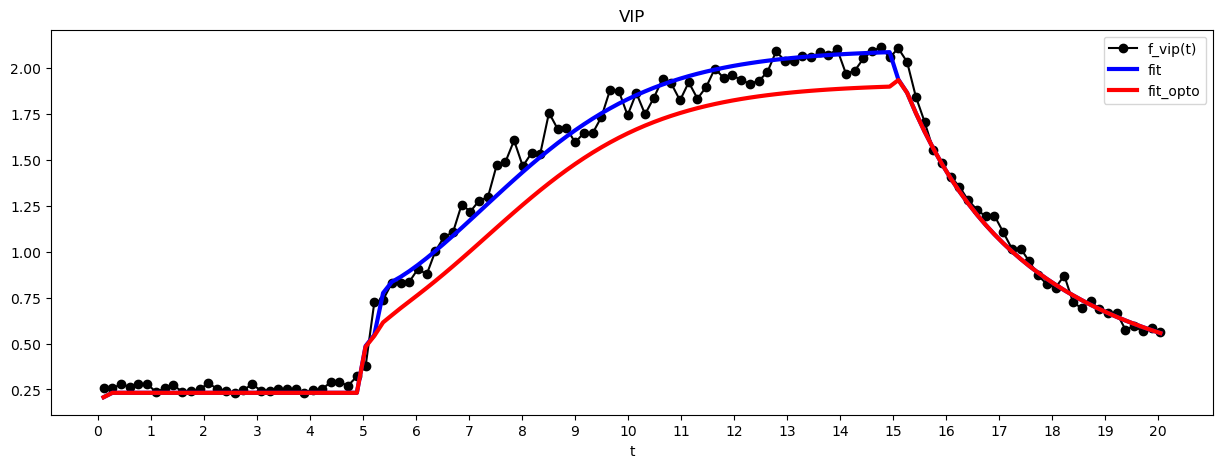

In [65]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_vip, color='black', marker='o', label='f_vip(t)')
plt.plot(t_exp, model_opto['f_vip'].values, color='blue', label='fit', linewidth=3)
plt.plot(t_exp, model_opto['f_vip_o'].values, color='red', label='fit_opto', linewidth=3)

plt.title('VIP')
plt.legend(loc='best')
plt.xlabel('t')
#plt.ylim(0, 2.2)
plt.xticks(np.arange(0,21,1))

plt.show()

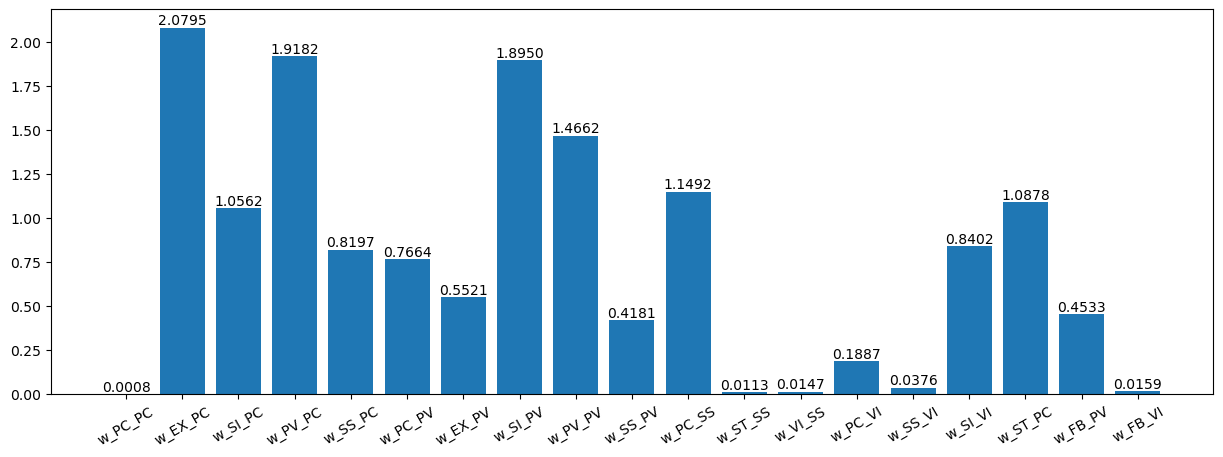

In [66]:
vals = []
for _, param in result_nelder.params.items():
    vals.append(param.value)
    
plt.figure(figsize=(15,5))
plt.bar(range(len(vals[:19])),vals[:19], color='blue')
plt.xticks(range(len(vals[:19])), names[:19], rotation = 30)
plt.bar_label(plt.bar(range(len(vals[:19])),vals[:19]), fmt = '{:.4f}')
plt.show()

In [76]:
heat_new = pd.DataFrame()
heat_new[''] = ['PC', 'PV', 'SST', 'VIP', 'FF', 'SM', 'FB']
heat_new['PC'] = [result_nelder.params["w_0"].value,
                  result_nelder.params["w_3"].value,
                  result_nelder.params["w_4"].value,
                  None,
                  result_nelder.params["w_1"].value,
                  result_nelder.params["w_2"].value,
                  result_nelder.params["w_16"].value]
heat_new['PV'] = [result_nelder.params["w_5"].value,
                  result_nelder.params["w_8"].value,
                  result_nelder.params["w_9"].value,
                  None,
                  result_nelder.params["w_6"].value,
                  result_nelder.params["w_7"].value,
                  result_nelder.params["w_17"].value]
heat_new['SST'] = [result_nelder.params["w_10"].value,
                   None,
                   None,
                   result_nelder.params["w_12"].value,
                   None,
                   None,
                   result_nelder.params["w_11"].value]
heat_new['VIP'] = [result_nelder.params["w_13"].value,
                   None,
                   result_nelder.params["w_14"].value,
                   None,
                   None,
                   result_nelder.params["w_15"].value,
                   result_nelder.params["w_18"].value]
heat_new.set_index('', inplace = True)

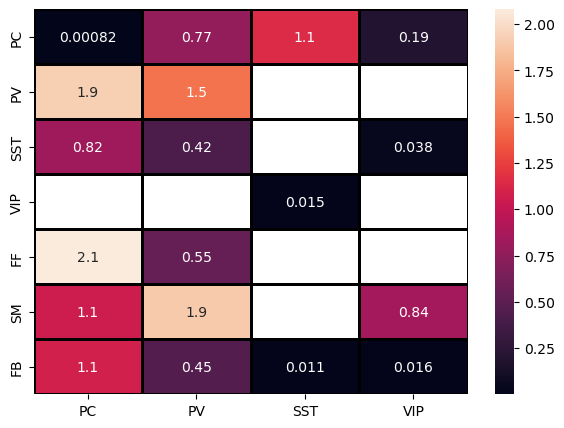

In [80]:
plt.figure(figsize=(7, 5))
sns.heatmap(heat_new, annot = True, linewidth = 1, linecolor = 'black')
plt.show()

## powell

In [81]:
count = 0

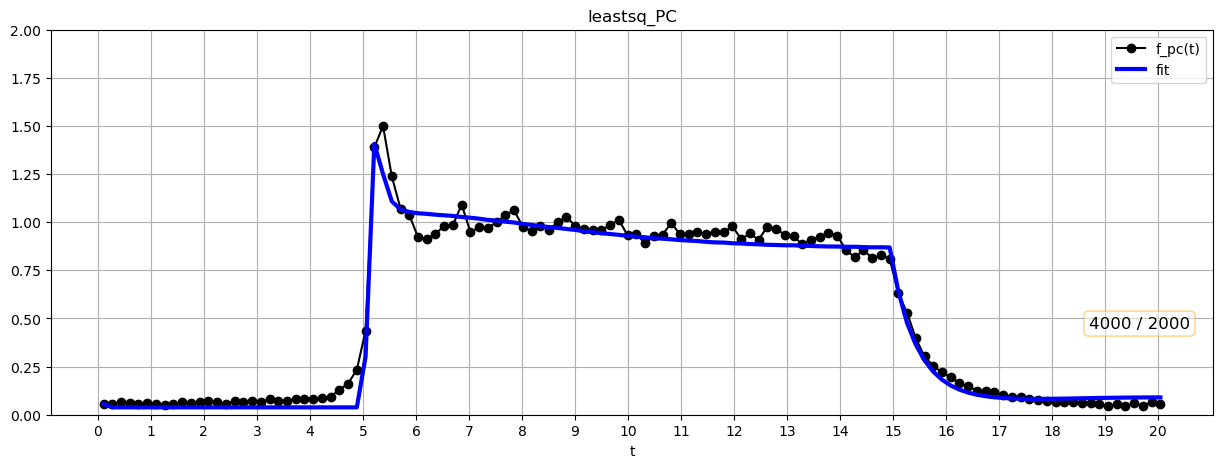


CPU times: total: 43min 3s
Wall time: 43min 17s


In [82]:
%%time
%matplotlib inline
result_powell = minimize(residual_step, params, method='powell', args=(t_exp, init, data_pc_all, data_pv, data_sst, data_vip), max_nfev = 2*max_nfev, nan_policy='propagate', tol=1e-14) #max_nfev = 4*max_nfev,
print()

In [83]:
report_fit(result_powell)

[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 4001
    # data points      = 488
    # variables        = 30
    chi-square         = 2658.83220
    reduced chi-square = 5.80531048
    Akaike info crit   = 887.319516
    Bayesian info crit = 1013.02898
##  Warning: uncertainties could not be estimated:
    w_12:       at initial value
    w_17:       at initial value
[[Variables]]
    w_0:        0.03732776 (init = 0.06505351)
    w_1:        1.59243925 (init = 1.516555)
    w_2:        1.52618785 (init = 1.699713)
    w_3:        1.77085253 (init = 1.821416)
    w_4:        0.56071172 (init = 0.6204221)
    w_5:        0.22155109 (init = 0.1947767)
    w_6:        0.53551552 (init = 0.5756015)
    w_7:        2.14690071 (init = 2.093994)
    w_8:        1.23606495 (init = 1.218958)
    w_9:        0.31876602 (init = 0.3059066)
    w_10:       1.00594413 (init = 1.01472)
    w_11:       0.59173651 (init = 0.5975994)
    w_12:       0.22494105 (init = 0.2249

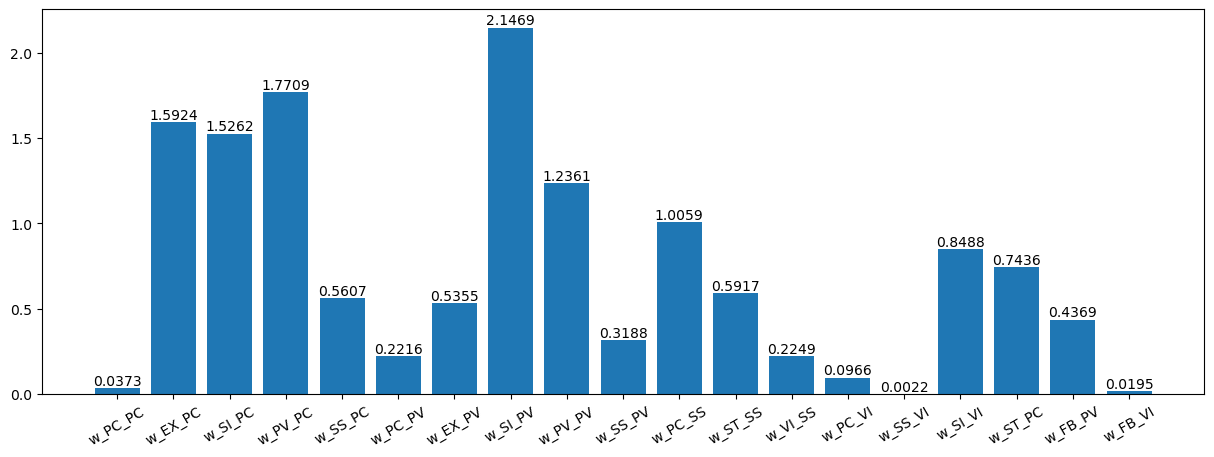

In [84]:
vals = []
for _, param in result_powell.params.items():
    vals.append(param.value)
    
plt.figure(figsize=(15,5))
plt.bar(range(len(vals[:19])),vals[:19], color='blue')
plt.xticks(range(len(vals[:19])), names[:19], rotation = 30)
plt.bar_label(plt.bar(range(len(vals[:19])),vals[:19]), fmt = '{:.4f}')
plt.show()

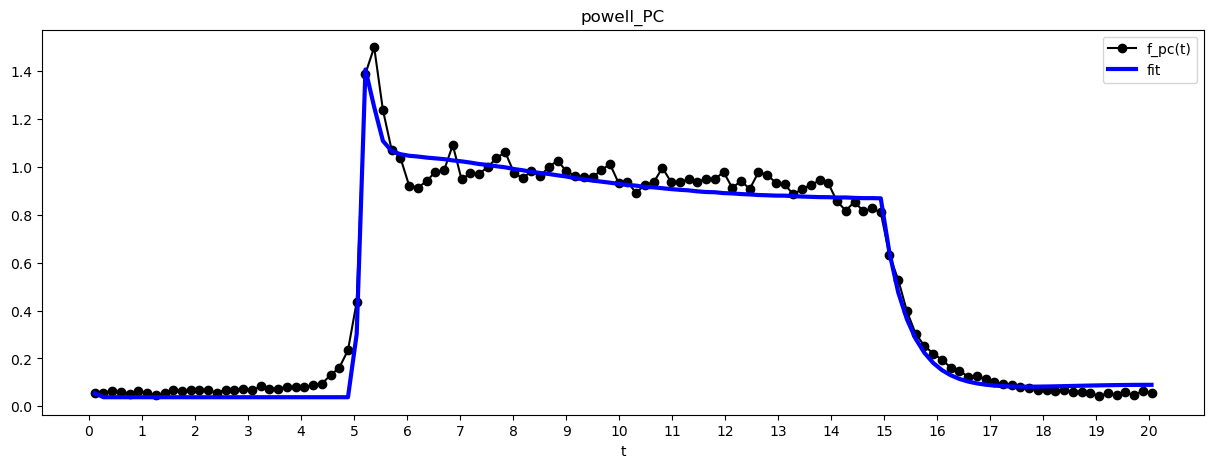

In [85]:
sim_powell = simulate_step(t_exp, init, params)
fit_powell = simulate_step(t_exp, init, result_powell.params)

plt.figure(figsize=(15,5))
plt.plot(t_exp, pc_all_new, color='black', marker='o', label='f_pc(t)')
plt.plot(t_exp, fit_powell['f_e'].values, color='blue', label='fit', linewidth=3)

plt.title('powell_PC')
plt.legend(loc='best')
plt.xlabel('t')
#plt.ylim(-0.1, 0.6)
plt.xticks(np.arange(0,21,1))

plt.show()

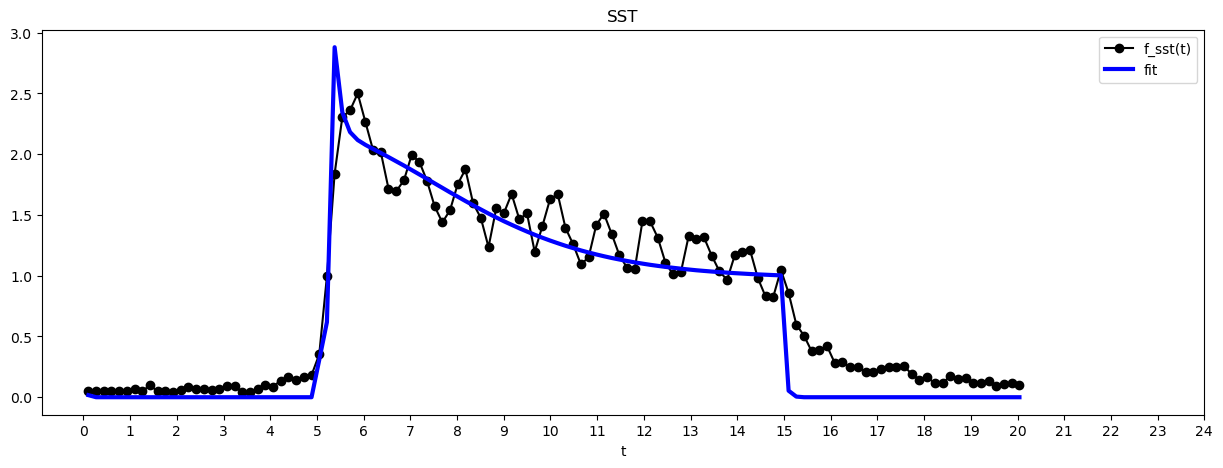

In [86]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_sst, color='black', marker='o', label='f_sst(t)')
plt.plot(t_exp, fit_powell['f_sst'].values, color='blue', label='fit', linewidth=3)

plt.title('SST')
plt.legend(loc='best')
plt.xlabel('t')
plt.xlim()
plt.xticks(np.arange(0,25,1))
#plt.grid()
plt.show()

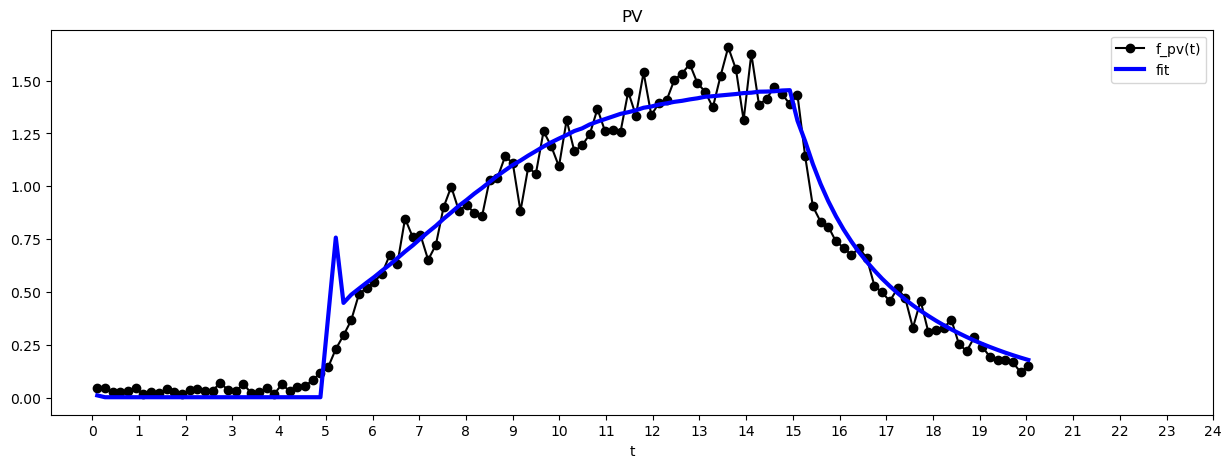

In [87]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_pv, color='black', marker='o', label='f_pv(t)')
plt.plot(t_exp, fit_powell['f_pv'].values, color='blue', label='fit', linewidth=3)

plt.title('PV')
plt.legend(loc='best')
plt.xlabel('t')
plt.xlim()
plt.xticks(np.arange(0,25,1))
#plt.grid()
plt.show()

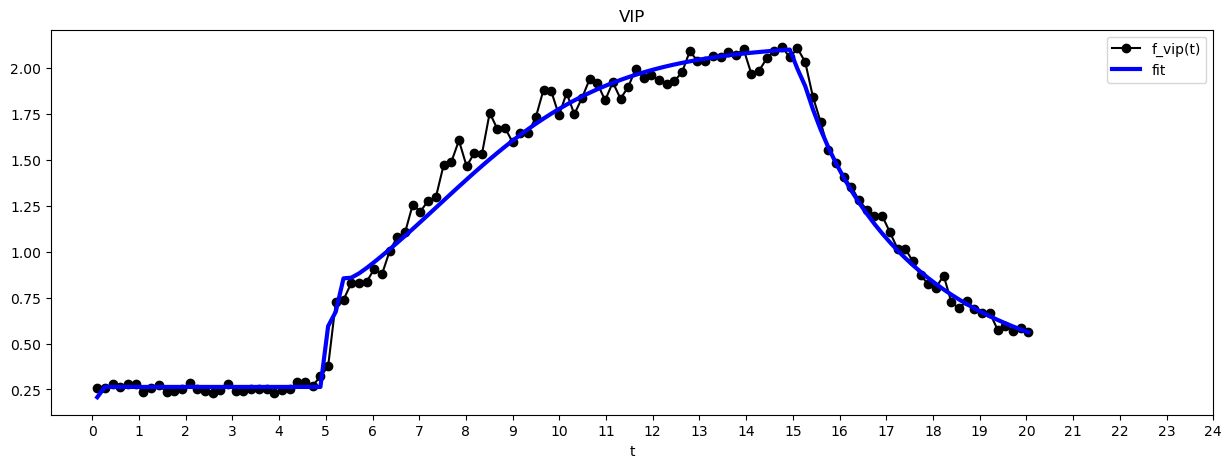

In [88]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_vip, color='black', marker='o', label='f_vip(t)')
plt.plot(t_exp, fit_powell['f_vip'].values, color='blue', label='fit', linewidth=3)

plt.title('VIP')
plt.legend(loc='best')
plt.xlabel('t')
plt.xlim()
plt.xticks(np.arange(0,25,1))
#plt.grid()
plt.show()